In [1]:
# @hidden_cell
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Paul M. Washburn

# Delivery Analysis

This analysis is being undertaken with the over arching goal of finding out whether dropping a truck lease is possible.  The first analysis looks at Saint Louis and Columbia only.  If warranted we will look at Kansas City and Springfield later.

# Data 

There are three sources of data used in this inquiry.  

- The Production Tab of the Daily Report
- Data extract from Hogan containing all of our invoice transactions since 2016 (through April 2018)
- Internal accounting data from the general ledger on Hogan invoices


# Goals

- Characterize the history of deliveyr patterns before/after Schlafly
- Learn about delivery patterns across houses
- Characterize rental costs since 2016 
- Simulate a likely future scenario and account for rental costs

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import glob
import re
import string
from collections import OrderedDict
import warnings

warnings.filterwarnings('ignore')
pd.set_option('max_rows', 99999999)
pd.set_option('max_columns', 99999999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Gather Production Tab of Daily Report 2016-2018

In [3]:
def extract_date_stl(file, year):
    '''Takes date from file name'''
    regex_criteria = re.compile(r'[0-9]+-[0-9]+')    
    dat = re.findall(regex_criteria, file)
    exclude = set(string.punctuation)
    dat = ''.join(d for d in dat if d not in exclude)
    dat = str(dat + '-' + year)
    dat = dt.strptime(str(dat), "%m-%d-%Y").date()
    return dat

def extract_stl_production_tab(file, year):
    '''
    Takes in and formats Production Tab from Daily Report. 
    Extracts date from filename and creates index.
    Puts into a dictionary of dataframes 
    for input into a pandas DataFrame.
    '''
    dtypes = {'Date':dt.date, 'Warehouse':str,'LOC':str,'RTE':str,'Driver':str,'Truck#':str,
            'Stops':np.float64,'TTL Cs/splt':np.float64,'Cs':np.float64,'Btls':np.float64,
            'Start Hr':str, 'End Hr':str,'Ttl Hrs':str,'Ttl Mi':np.float64 }
    try:
        df = pd.read_excel(file, sheet_name='Production', converters=dtypes)
    except ValueError:
        df = pd.read_excel(file, sheet_name='Production')        
        
    dat = extract_date_stl(file, year)
    
    df['Date'] = dat 
    df['Month'] = dat.strftime('%B')
    df['Weekday'] = dat.strftime('%A')
    df['WeekNumber'] = dat.strftime('%U')
    df['DOTM'] = dat.strftime('%d')
    df['Warehouse'] = 'STL'
    
    keep_cols = ['Date','Warehouse','LOC','RTE','Driver','Truck#','Stops',
                 'TTL Cs/splt','Cs','Btls','Start Hr',
                 'End Hr','Ttl Hrs','Ttl Mi','Month','Weekday','WeekNumber',
                 'DOTM']
    df = df[keep_cols].drop_duplicates()
    
    WAREHOUSE, ROUTE = df.Warehouse.astype(str), df.RTE.astype(str)
    new_index = WAREHOUSE + '_' + ROUTE 
    
    df.set_index(new_index, inplace=True)
    
    df = df[df['Driver'] != 'Totals:']        
    df = df.sort_values(['Stops','TTL Cs/splt'], ascending=False).reset_index(drop=False)
    
    df['Date'] = df['Date'].replace(to_replace='NaN', value='')
    df = df[df['Date'].isnull() == False]
    
    drop_dumb_shit = lambda col: str(col).lower().replace(' ', '_').replace('#', '').replace('.', '')
    df.columns = [drop_dumb_shit(col) for col in df.columns]
    
    return df

In [4]:
## Update years like on velocity
files_2018 = 'N:\\Daily Report\\2018\\*\\*.xls*'
files_2017 = 'N:\\Daily Report\\2017\\*\\*.xls*'
files_2016 = 'N:\\Daily Report\\2016\\*\\*.xls*'

file_list = {'2016': files_2016, '2017': files_2017, '2018': files_2018}

stl_production = pd.DataFrame()        
for k, v in file_list.items():
    flist = glob.glob(v)
    yr = k
    for file in flist:
        if 'copy' in str(file).lower():
            print('Excluding file:  {}'.format(file))
            pass
        elif '~$' in str(file):
            print('Excluding file:  {}'.format(file))
            pass
        else:
            df  = extract_stl_production_tab(file, year=yr)
            stl_production = stl_production.append(df)
            
stl_production.tail()

Excluding file:  N:\Daily Report\2017\FEB\Copy of 02-20.xlsx
Excluding file:  N:\Daily Report\2017\FEB\Copy of 02-21.xlsx
Excluding file:  N:\Daily Report\2017\MAR\Copy of 03-16.xlsx
Excluding file:  N:\Daily Report\2017\MAY\05-17 COPY.xlsx
Excluding file:  N:\Daily Report\2017\MAY\05-18 - Copy.xlsx
Excluding file:  N:\Daily Report\2017\MAY\Copy of 05-03.xlsx
Excluding file:  N:\Daily Report\2017\MAY\Copy of 05-04.xlsx
Excluding file:  N:\Daily Report\2018\MAR\~$03-21.xlsx
Excluding file:  N:\Daily Report\2018\MAR\~$03-22.xlsx


,index,date,warehouse,loc,rte,driver,truck,stops,ttl_cs/splt,cs,btls,start_hr,end_hr,ttl_hrs,ttl_mi,month,weekday,weeknumber,dotm
48,STL_389,2018-03-29,STL,COL,389,BATES,RT 388,1,101,101.3,41,NaN,NaN,00:00:00,0,March,Thursday,12,29
49,STL_66,2018-03-29,STL,STL,66,0,0,0,0,0,0,NaN,NaN,00:00:00,0,March,Thursday,12,29
50,STL_99,2018-03-29,STL,STL,99,KC TRANSFER,0,0,0,0,0,NaN,NaN,00:00:00,0,March,Thursday,12,29
51,STL_PR,2018-03-29,STL,STL,PR,PRIORITIES,0,0,0,0,0,NaN,NaN,00:00:00,0,March,Thursday,12,29
52,STL_nan,2018-03-29,STL,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00,0,March,Thursday,12,29


In [5]:
ix_cols = ['date', 'warehouse', 'rte']
stl_production.sort_values(ix_cols, inplace=True)
stl_production.set_index(ix_cols, inplace=True, drop=False)

## Offset Date Contained in File Name to Next Day 

The Daily Report is named for the day of routing, not delivery.  To get the correct delivery day the routing date is changed to the delivery date.

In [6]:
stl_production['date'] = stl_production['date'] + pd.to_timedelta(1, unit='d')
stl_production['weekday'] = stl_production['date'].apply(lambda d: d.weekday())
wday_map = dict(zip(np.arange(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
stl_production['weekday'] = stl_production['weekday'].map(wday_map)

## Inspect Routes in Daily Report

In [7]:
print(sorted(stl_production.loc[stl_production['loc']=='CAPE', 'index'].unique()))

['STL_406', 'STL_407', 'STL_408', 'STL_409', 'STL_410', 'STL_411', 'STL_412', 'STL_413', 'STL_414', 'STL_415', 'STL_416', 'STL_417', 'STL_418', 'STL_419', 'STL_420', 'STL_421', 'STL_422', 'STL_423']


In [8]:
print(sorted(stl_production.loc[stl_production['loc']=='STL', 'index'].unique()))

['STL_12', 'STL_13', 'STL_14', 'STL_15', 'STL_152509', 'STL_16', 'STL_17', 'STL_18', 'STL_19', 'STL_20', 'STL_21', 'STL_22', 'STL_23', 'STL_24', 'STL_25', 'STL_26', 'STL_27', 'STL_28', 'STL_29', 'STL_3', 'STL_30', 'STL_301', 'STL_31', 'STL_310', 'STL_311', 'STL_318', 'STL_32', 'STL_33', 'STL_34', 'STL_35', 'STL_36', 'STL_37', 'STL_38', 'STL_39', 'STL_40', 'STL_41', 'STL_43', 'STL_45', 'STL_51', 'STL_53', 'STL_54', 'STL_60', 'STL_61', 'STL_63', 'STL_64', 'STL_65', 'STL_66', 'STL_67', 'STL_68', 'STL_69', 'STL_7', 'STL_70', 'STL_71', 'STL_72', 'STL_73', 'STL_74', 'STL_75', 'STL_76', 'STL_77', 'STL_78', 'STL_79', 'STL_80', 'STL_81', 'STL_82', 'STL_83', 'STL_84', 'STL_85', 'STL_86', 'STL_87', 'STL_88', 'STL_89', 'STL_9', 'STL_90', 'STL_91', 'STL_92', 'STL_93', 'STL_97', 'STL_98', 'STL_99', 'STL_PR']


In [9]:
print(sorted(stl_production.loc[stl_production['loc']=='COL', 'index'].unique()))

['STL_301', 'STL_319', 'STL_320', 'STL_321', 'STL_322', 'STL_323', 'STL_324', 'STL_325', 'STL_326', 'STL_327', 'STL_328', 'STL_330', 'STL_332', 'STL_333', 'STL_334', 'STL_335', 'STL_336', 'STL_337', 'STL_343', 'STL_346', 'STL_347', 'STL_348', 'STL_349', 'STL_350', 'STL_351', 'STL_352', 'STL_353', 'STL_354', 'STL_356', 'STL_358', 'STL_360', 'STL_363', 'STL_364', 'STL_365', 'STL_366', 'STL_367', 'STL_372', 'STL_373', 'STL_376', 'STL_379', 'STL_380', 'STL_381', 'STL_382', 'STL_383', 'STL_384', 'STL_385', 'STL_386', 'STL_387', 'STL_388', 'STL_389', 'STL_390', 'STL_392', 'STL_393', 'STL_394', 'STL_395', 'STL_396', 'STL_397']


## ***Filter Out Non-Routes***

This list was given by Bob Kloeppinger to filter out of the dataset.  Columbia is assumed to send all routes to market.  Cape is being excluded due to its size.

Also lines that have no stops are being dropped from the dataset.

In [10]:
#['STL_70', 'STL_91', 'STL_PR', 'STL_nan', 'STL_90', 'STL_93', 'STL_13', 'STL_3', 'STL_25']
nontrue_routes = ['STL_70', 'STL_91', 'STL_PR', 'STL_nan', 'STL_90', 'STL_93',     # not true routes
                 'STL_13', 'STL_3', 'STL_25', 'STL_nan',                           # not true routes
                 'STL_93', 'STL_97', 'STL_98', 'STL_99',                           # from paul C 
                 'STL_389', 'STL_319',                                    # from paul C combine/sales takes col 
                 'STL_406', 'STL_407', 'STL_408', 'STL_409', 'STL_410', 'STL_411', # excluding all CAPE
                 'STL_412', 'STL_413', 'STL_414', 'STL_415', 'STL_416', 'STL_417', # excluding all CAPE
                 'STL_418', 'STL_419', 'STL_420', 'STL_421', 'STL_422', 'STL_423'] # excluding all CAPE
nontrue_rtes = stl_production['index'].isin(nontrue_routes)
stl_production = stl_production.loc[~nontrue_rtes]
# stl_production = stl_production.loc[stl_production['stops'].astype(np.int64) > 0]

In [11]:
sams = ['STL_323', 'STL_324'] #sams both col/jeffcity these get combined if rte is below 200 cases
print('This Sams issue is not dealt with.  Sometimes they combine these routes, sometimes not.')

This Sams issue is not dealt with.  Sometimes they combine these routes, sometimes not.


In [12]:
def stl_daily_route_summary(stl_production):
    grpby_df = stl_production.loc[stl_production['loc'].isin(['STL', 'COL'])]
    print('Replacing Driver with Route ID for COLUMBIA ONLY because they do not have their Driver Names in the data.')
    grpby_df.loc[grpby_df['loc']=='COL', 'driver'] = grpby_df.loc[grpby_df['loc']=='COL', 'rte']
    grpby_df['driver'] = grpby_df['driver'].apply(lambda s: 'dr_' + str(s).strip().lower().replace('/', '_').replace(' ', ''))
    grpby_df['driver'] = grpby_df['driver'].astype(str)
    grp_cols = ['warehouse', 'loc', 'date']
    agg_funcs = {'driver': pd.Series.nunique, 'stops': np.sum, 'ttl_cs/splt': np.sum}
    print('Counting DRIVER as the route per PAUL C recommendation')
    grpby_df = pd.DataFrame(grpby_df.groupby(grp_cols).agg(agg_funcs)).reset_index(drop=False)
    grpby_df['date'] = pd.to_datetime(grpby_df['date'])
    grpby_df.rename(columns={'driver': 'rte'}, inplace=True)
    return grpby_df

stl_daily = stl_daily_route_summary(stl_production)
stl_daily.head()

Replacing Driver with Route ID for COLUMBIA ONLY because they do not have their Driver Names in the data.
Counting DRIVER as the route per PAUL C recommendation


,warehouse,loc,date,rte,stops,ttl_cs/splt
0,STL,COL,2016-01-04,9,41.0,1721.0
1,STL,COL,2016-01-05,9,117.0,2396.0
2,STL,COL,2016-01-06,11,150.0,2539.0
3,STL,COL,2016-01-07,9,143.0,1802.0
4,STL,COL,2016-01-08,10,167.0,2091.0


## Merge in Calendar Attributes

In [13]:
# merge in calendar data
def generate_calendar(year, drop_index=False):
    '''
    Simple function to generate a calendar containing
    US holidays, weekdays and  holiday weeks.
    '''
    from pandas.tseries.offsets import YearEnd
    from pandas.tseries.holiday import USFederalHolidayCalendar
    
    start_date = pd.to_datetime('1/1/'+str(year))
    end_date = start_date + YearEnd()
    DAT = pd.date_range(str(start_date), str(end_date), freq='D')
    MO = [d.strftime('%B') for d in DAT]
    holidays = USFederalHolidayCalendar().holidays(start=start_date, end=end_date)

    cal_df = pd.DataFrame({'date':DAT, 'month':MO})
    cal_df['year'] = [format(d, '%Y') for d in DAT]
    cal_df['weekday'] = [format(d, '%A') for d in DAT]
    cal_df['is_weekday'] = cal_df.weekday.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])
    cal_df['is_weekday'] = cal_df['is_weekday'].astype(int)
    cal_df['is_holiday'] = cal_df['date'].isin(holidays)
    cal_df['is_holiday'] = cal_df['is_holiday'].astype(int)
    cal_df['is_holiday_week'] = cal_df.is_holiday.rolling(window=7,center=True,min_periods=1).sum()
    cal_df['is_holiday_week'] = cal_df['is_holiday_week'].astype(int)
    production_days = ['Tuesday','Wednesday','Thursday','Friday']
    cal_df['is_production_day'] = cal_df.weekday.isin(production_days)
    cal_df['is_production_day'] = cal_df['is_production_day'].astype(int)
    last_biz_day = [str(format(dat, '%Y-%m-%d')) 
                    for dat in pd.date_range(start_date, end_date, freq='BM')]
    cal_df['last_selling_day'] = [int(dat in last_biz_day) for dat in cal_df['date'].astype(str)]
    
    if not drop_index: cal_df.set_index('date', inplace=True)
    
    return cal_df

def make_calendars(year_list, drop_index):
    cal_df = pd.DataFrame()
    for year in year_list:
        cal_df = cal_df.append(generate_calendar(year, drop_index=drop_index))
    return cal_df

year_list = ['2016', '2017', '2018']
cal_df = make_calendars(year_list, drop_index=True)

# merge in calendar
stl_daily = stl_daily.merge(cal_df, on='date')
stl_daily.sort_values(['date', 'loc'], inplace=True)

# save to disk
stl_daily.to_excel('stl_daily_report__production_tab__jan2016_apr2018.xlsx')

stl_daily.head()

,warehouse,loc,date,rte,stops,ttl_cs/splt,month,year,weekday,is_weekday,is_holiday,is_holiday_week,is_production_day,last_selling_day
0,STL,COL,2016-01-04,9,41.0,1721.0,January,2016,Monday,1,0,1,0,0
1,STL,STL,2016-01-04,16,136.0,5269.0,January,2016,Monday,1,0,1,0,0
2,STL,COL,2016-01-05,9,117.0,2396.0,January,2016,Tuesday,1,0,0,1,0
3,STL,STL,2016-01-05,30,706.0,12073.0,January,2016,Tuesday,1,0,0,1,0
4,STL,COL,2016-01-06,11,150.0,2539.0,January,2016,Wednesday,1,0,0,1,0


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')


def plot_tseries_over_group_with_histograms(df, xcol, ycol, grpcol, title_prepend='{}', 
                                            labs=None, x_angle=0, labelpad=60, window=20, 
                                            vertical_col=None, vertical_label='', logy=False,
                                            savefig=False, fname='fig.png'):
    '''
    Function for plotting time series df[ycol] over datetime range df[xcol]
    using the unique_grp_vals contained in df[grpcol].unique().  
    
     - df: pd.DataFrame containing datetime and series to plot
     - xcol: str of column name in df for datetime series
     - ycol: str of column name in df for tseries 
     - grpcol: str of column name in df of group over which to plot
     - labs: dict of xlab, ylab
     - title_prepend: str containing "{}" that prepends group names in title
    '''
    unique_grp_vals = df[grpcol].unique()
    nrows = len(unique_grp_vals) // 2
    figsize = (15, 14 * nrows)
    fig, axes = plt.subplots(len(unique_grp_vals), 1, figsize=figsize)
    title_prepend_hist = 'Histogram of ' + str(title_prepend)
    j = 0
    for i, grp in enumerate(unique_grp_vals):
        _df = df.loc[df[grpcol] == grp]
        ax = axes[i]
        ax.plot(_df[xcol], _df[ycol], alpha=.7, color='black', linewidth=0.35)
        ax.plot(_df[xcol], _df[ycol].rolling(window=window, min_periods=min(5, window)).mean(), 
                alpha=.8, color='r', label='{} period rolling avg'.format(window),
                linestyle='--', linewidth=1.5)
        longer_window = int(window * 3)
        ax.plot(_df[xcol], _df[ycol].rolling(window=longer_window, min_periods=5).mean(), 
                alpha=.9, color='darkred', label='{} period rolling avg'.format(longer_window),
                linewidth=2.25)
        mu, sigma = _df[ycol].mean(), _df[ycol].std()
        ax.axhline(mu, linestyle='--', color='r', alpha=.5, linewidth=.3)
        ax.axhline(mu - sigma, linestyle='-.', color='y', alpha=.5, linewidth=.3)
        ax.axhline(mu + sigma, linestyle='-.', color='y', alpha=.5, linewidth=.3)
        ax.set_title(title_prepend.format(grp))
        bottom, top = mu - 3*sigma, mu + 3*sigma
        ax.set_ylim((bottom, top))
        if labs is not None:
            ax.set_xlabel(labs['xlab'])
            ax.set_ylabel(labs['ylab'])
        ax.xaxis.labelpad = labelpad
        ax.xaxis.set_minor_locator(months)
        ax.grid(alpha=.1)
        if x_angle != 0:
            for tick in ax.get_xticklabels():
                tick.set_rotation(x_angle)
        if vertical_col is not None:
            for dat, plotit in zip(_df[xcol], _df[vertical_col]):
                if plotit == 1: 
                    ax.axvline(dat, color='lightblue', alpha=.4, label=vertical_label)
                    vertical_label = ''
        if logy:
            ax.set_yscale('log')
        ax.legend(loc='best')

        divider = make_axes_locatable(ax)
        axHisty = divider.append_axes('right', 1.2, pad=0.1, sharey=ax)
        axHisty.grid(alpha=.1)
        axHisty.hist(_df[ycol].dropna(), orientation='horizontal', alpha=.5, 
                     color='lightgreen', bins=25)
        axHisty.axhline(mu, linestyle='--', color='r', label='mu', 
                        alpha=.5, linewidth=.3)
        axHisty.axhline(mu - sigma, linestyle='-.', color='y', label='+/- two sigma', 
                       alpha=.5, linewidth=.3)
        axHisty.axhline(mu + sigma, linestyle='-.', color='y', alpha=.5, linewidth=.3)
        axHisty.legend(loc='best')
        
        j += 1
                
    sns.set_style("whitegrid")
    sns.despine()
    if savefig: plt.savefig(fname)
    plt.show()

## Keep Only Production Days & Plot Series

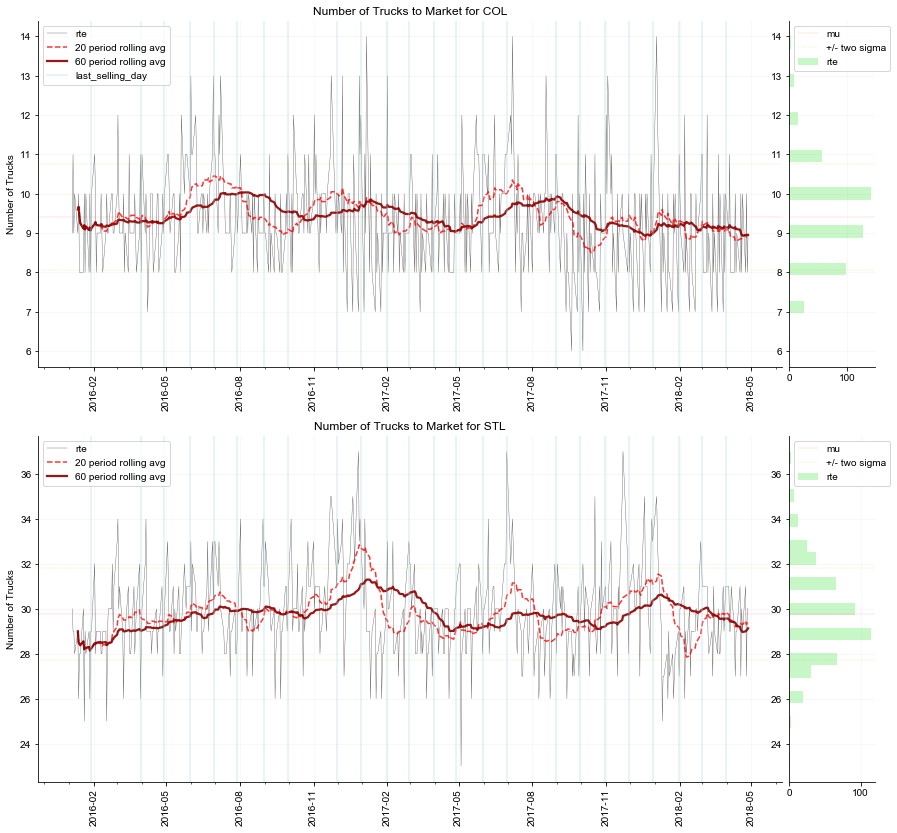

In [15]:
title_prepend = 'Number of Trucks to Market for {}'
xcol = 'date'
ycol = 'rte'
grpcol = 'loc'
labs = dict(xlab='', ylab='Number of Trucks')
vertical_col = 'last_selling_day'#'is_holiday_week'
vertical_label = 'last_selling_day'#'is_holiday_week'

is_prod_day = stl_daily.is_production_day == True
stl_daily_prdday = stl_daily.loc[is_prod_day]

plot_tseries_over_group_with_histograms(stl_daily_prdday, xcol, ycol, grpcol,
                                       title_prepend, labs, 
                                       x_angle=90,
                                       vertical_col=vertical_col, 
                                       vertical_label=vertical_label,
                                       savefig=True,
                                       fname='./figs/tseries_dailyrpt_trucks.png')

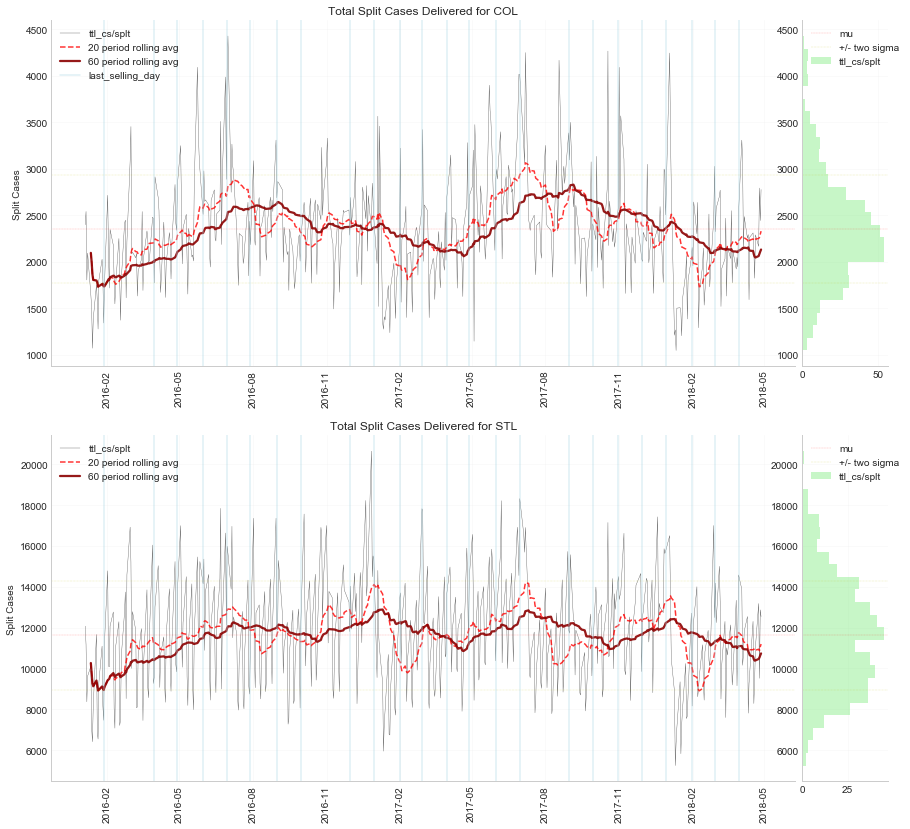

In [16]:
title_prepend = 'Total Split Cases Delivered for {}'
xcol = 'date'
ycol = 'ttl_cs/splt'
grpcol = 'loc'
labs = dict(xlab='', ylab='Split Cases')
    
plot_tseries_over_group_with_histograms(stl_daily_prdday, xcol, ycol, grpcol, title_prepend, labs,  
                                       x_angle=90,
                                       vertical_col=vertical_col, 
                                       vertical_label=vertical_label,
                                       savefig=True,
                                       fname='./figs/tseries_dailyrpt_splits.png')

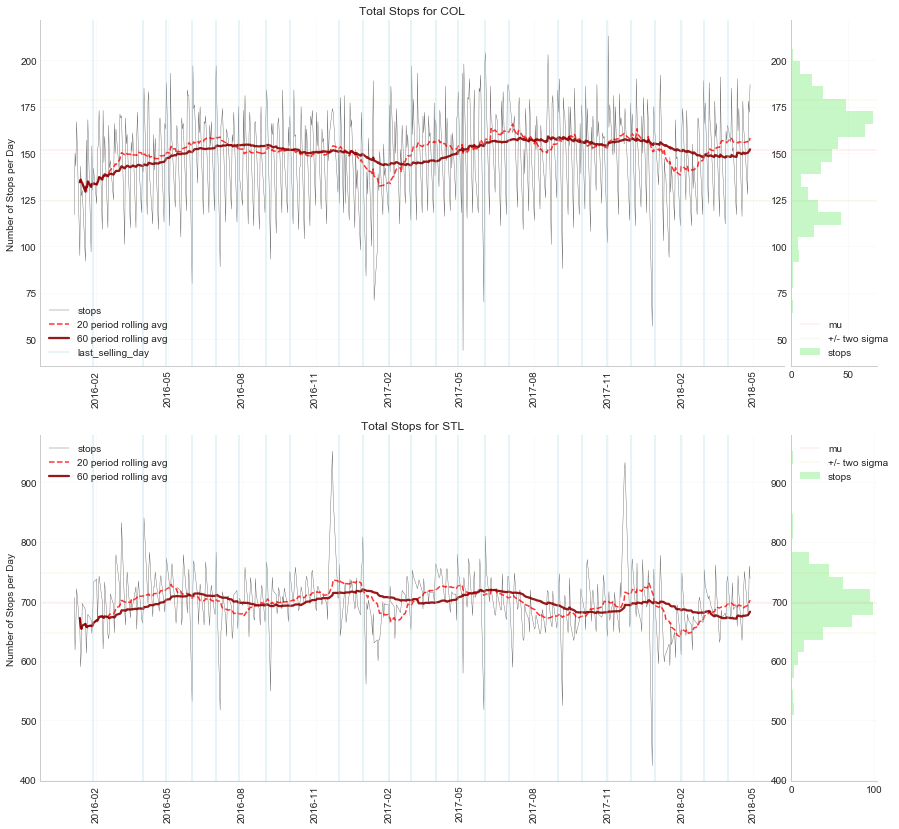

In [17]:
title_prepend = 'Total Stops for {}'
xcol = 'date'
ycol = 'stops'
grpcol = 'loc'
labs = dict(xlab='', ylab='Number of Stops per Day')

plot_tseries_over_group_with_histograms(stl_daily_prdday, xcol, ycol, grpcol, title_prepend, labs,  
                                       x_angle=90,
                                       vertical_col=vertical_col, 
                                       vertical_label=vertical_label,
                                       savefig=True,
                                       fname='./figs/tseries_dailyrpt_stops.png')

--------------

--------------

--------------

# Prepare Data for Machine Learning

We need a model that predicts split cases and a model that predicts number of routes.  

In [18]:
# rename columns to better semantically oriented names
new_colnames = {'rte': 'routes_per_day', 
               'ttl_cs/splt': 'split_cases_delivered_per_day', 
               'stops': 'stops_per_day',
               'loc': 'location'}
stl_daily_prdday.rename(columns=new_colnames, inplace=True)

In [19]:
def preprocess_train_test(df):
    df['date'] = pd.to_datetime(df['date'])
    df['bill_and_hold'] = [int(i) for i in df['date'].dt.day.astype(int) <= 5]
    df['schlafly'] = [int(i) for i in df['date'] <= pd.to_datetime('2017-07-31')]
    
    keep_cols = ['location', 'routes_per_day', 'month', 'date',
                 'split_cases_delivered_per_day', 'stops_per_day', 'weekday', 'year', 
                 'last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly']
    df = df.loc[:, keep_cols]

    dummy_cols = ['location', 'weekday', 'year', 'month']
    df = pd.get_dummies(df, columns=dummy_cols, drop_first=False)
    drop_space_lowercase = lambda s: str(s).replace(' ', '_').lower()
    df.columns = [drop_space_lowercase(col) for col in df.columns]
    df.reset_index(drop=True, inplace=True)
    return df

df_modeling = preprocess_train_test(stl_daily_prdday)

### Split Data to Training & Testing & Scale the Data with `StandardScaler`

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def split_scale_data(df_modeling, y_col, leave_out, train_size=.8, continuous_cols=[]):
    print('''Using X columns:'''); print(X_cols)
    print('''To predict Y column:'''); print(y_col)
    
    X_train, X_test, y_train, y_test = train_test_split(df_modeling[X_cols], 
                                                        df_modeling[y_col], 
                                                        train_size=train_size)
    if len(continuous_cols) > 0:
        std = StandardScaler()
        std.fit(X_train[continuous_cols].as_matrix())
        X_train[continuous_cols] = std.transform(X_train[continuous_cols])
        X_test[continuous_cols] = std.transform(X_test[continuous_cols])
    else: 
        std = None
    
    return X_train, X_test, y_train, y_test, std

In [21]:
y_col = 'routes_per_day'
leave_out = ['date', 'stops_per_day'] + [y_col] 
X_cols = [col for col in df_modeling.columns if col not in leave_out]

continuous_cols = ['split_cases_delivered_per_day']

X_train, X_test, y_train, y_test, std_scaler = split_scale_data(df_modeling, 
                                                               y_col, 
                                                               leave_out, 
                                                               train_size=.8,
                                                               continuous_cols=continuous_cols)

# split off hold out set
pct_hold_out = .5
nrow_train = int(pct_hold_out * X_test.shape[0])
X_val, y_val = X_test.iloc[:nrow_train], y_test.iloc[:nrow_train]
X_test, y_test = X_test.iloc[nrow_train:], y_test.iloc[nrow_train:]
print('Shape X_val: {}, Shape X_test: {}'.format(X_val.shape, X_test.shape))

Using X columns:
['split_cases_delivered_per_day', 'last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september']
To predict Y column:
routes_per_day
Shape X_val: (96, 26), Shape X_test: (96, 26)


# Machine Learning

### Test `RandomForestRegressor` Predicting `routes_per_day`

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.externals import joblib

param_grid = {'n_estimators': np.arange(78, 91, 2),
             'max_features': np.arange(.5, .71, .02)}
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=777,
                              criterion='mse')

grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

val_score = r2_score(y_val, [int(pred) for pred in grid.predict(X_val)])
test_score = r2_score(y_test, [int(pred) for pred in grid.predict(X_test)])
train_score = r2_score(y_train, [int(pred) for pred in grid.predict(X_train)])

print('Train Score = {}, Validation Score = {}, Test Score = {}'
      .format(train_score, val_score, test_score))

joblib.dump(grid.best_estimator_, 'rtes_per_day_model_rf.pkl')

grid.best_params_

Train Score = 0.9954829864008874, Validation Score = 0.9889020521125327, Test Score = 0.9866915373821505


{'max_features': 0.54, 'n_estimators': 86}

### Test `RandomForestRegressor` to Predict `split_cases_delivered_per_day`

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

y_col = 'split_cases_delivered_per_day'
leave_out = ['date', 'stops_per_day', 'routes_per_day'] + [y_col]
X_cols = [col for col in df_modeling.columns if col not in leave_out]
continuous_cols = []

X_train, X_test, y_train, y_test, std_scaler = split_scale_data(df_modeling, 
                                                               y_col, 
                                                               leave_out, 
                                                               train_size=.8,
                                                               continuous_cols=continuous_cols)

# split off hold out set
pct_hold_out = .5
nrow_train = int(pct_hold_out * X_test.shape[0])
X_val, y_val = X_test.iloc[:nrow_train], y_test.iloc[:nrow_train]
X_test, y_test = X_test.iloc[nrow_train:], y_test.iloc[nrow_train:]

param_grid = {'n_estimators': np.arange(250, 751, 50),
             'max_features': np.arange(.30, .45, .02)}
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=777,
                              criterion='mse')

grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

val_score = r2_score(y_val, [int(pred) for pred in grid.predict(X_val)])
test_score = r2_score(y_test, [int(pred) for pred in grid.predict(X_test)])
train_score = r2_score(y_train, [int(pred) for pred in grid.predict(X_train)])

print('Train Score = {}, Validation Score = {}, Test Score = {}'
      .format(train_score, val_score, test_score))

joblib.dump(grid.best_estimator_, 'splits_per_day_rf.pkl')

grid.best_params_

Using X columns:
['last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september']
To predict Y column:
split_cases_delivered_per_day
Train Score = 0.9722420240279784, Validation Score = 0.9346649341873335, Test Score = 0.9389205493027466


{'max_features': 0.4400000000000001, 'n_estimators': 300}

---------------------------------------------------------------------------

---------------

---------------

# Hogan Data

Data below is sent directly from Hogan.

Reindex data so zeros show up for all weekdays not used.  Select for only T-F only in all datasets.

## Read in Data

In [24]:
base_dir = 'N:\\Operations Intelligence\\Operations Research\\Delivery Analysis Post Schlafly\\'
hogan_xlsx = pd.ExcelFile(base_dir + 'FROM HOGAN Rental_Contract_Revenue_Detail.xlsx')
hogan = hogan_xlsx.parse('Rental Contract Revenue Detail', header=0)
hogan['Contract Billing Date'] = hogan['Contract Billing Date'].apply(pd.to_datetime)
hogan_xlsx.close()
hogan.columns = [str(col).replace(' ', '_').lower() for col in hogan.columns]

In [50]:
hogan.head()

,unit_number,agreement__number,contract__base_amount,contract__billed_rate,contract__billed_amount,contract_billing_date,contract_type,section,invoice_number,customer_number,customer_name,equip_type,vehicle_description,serial_number,year_-_make_-_model,customer_class_code,customer_class_description,loc
0,282501,260734,2,85.50000,171.00,2018-03-30,DR,FIXED,282501,001-30000404-000,"MAJOR BRANDS, INC.",24,ST.TRK ≥20' CDL (33K#GVW),1HTMMMMN3JH445535,2018 INTERNATIONAL 4300,MAJOR,MAJOR BRANDS,STL
1,282501,260734,105,0.12000,12.60,2018-03-30,DR,MILES,282501,001-30000404-000,"MAJOR BRANDS, INC.",24,ST.TRK ≥20' CDL (33K#GVW),1HTMMMMN3JH445535,2018 INTERNATIONAL 4300,MAJOR,MAJOR BRANDS,STL
2,262066,249366,1,317.83100,317.83,2018-03-30,DR,FIXED,262066,001-30000406-000,MAJOR BRANDS-(Springfield),22,ST.TRK ≥20' NCDL (26K#GVW),3HAMMMML5GL194521,2016 INTERNATIONAL 4300,MAJOR,MAJOR BRANDS,SPFD
3,262066,249366,112,0.08045,9.01,2018-03-30,DR,MILES,262066,001-30000406-000,MAJOR BRANDS-(Springfield),22,ST.TRK ≥20' NCDL (26K#GVW),3HAMMMML5GL194521,2016 INTERNATIONAL 4300,MAJOR,MAJOR BRANDS,SPFD
4,243012,253817,1,354.86000,354.86,2018-03-30,DR,FIXED,243012,001-30000406-000,MAJOR BRANDS-(Springfield),32,REEFER ST.TRK ≥20' NON-CDL,3HAMNAAL9EL767398,2014 4300LP INTERNATIONAL,MAJOR,MAJOR BRANDS,SPFD


## Map in Customer Names

In [25]:
cust_id_map = {'001-30000404-000': 'STL', 
               '001-30000406-000': 'SPFD', 
               '001-30000848-000': 'KC', 
               '001-30000884-000': 'COL', 
               '001-30007850-000': 'POS'}
hogan['loc'] = hogan.customer_number.map(cust_id_map) 
print('Dropping Van Rentals from Hogan Data')
hogan = hogan.loc[hogan['loc'] != 'POS']
hogan['loc'].unique()

Dropping Van Rentals from Hogan Data


array(['STL', 'SPFD', 'KC', 'COL'], dtype=object)

## Aggregate by Day and Location

In [26]:
print('Doing Count-Unique Operation on unit_number NOT invoice_number')
hogan['invoice_number'] = hogan['unit_number']
aggfuncs = {'contract__billed_amount': np.sum, 'invoice_number': pd.Series.nunique}
grpcols = ['loc', 'contract_billing_date']
hogan_byday = pd.DataFrame(hogan.groupby(grpcols).agg(aggfuncs)).reset_index(drop=False)
hogan_byday.rename(columns={'contract_billing_date': 'date', 'loc': 'loc'}, inplace=True)
hogan_byday.head()

Doing Count-Unique Operation on unit_number NOT invoice_number


,loc,date,contract__billed_amount,invoice_number
0,COL,2016-05-27,238.00,1
1,COL,2016-06-07,1228.42,1
2,COL,2016-07-08,1071.00,1
3,COL,2016-07-13,-818.50,1
4,COL,2016-07-15,699.50,1


## Spread Negatives Over Entire Series

There are quite a few negative days in the data.  To take care of this without losing integrity in the data an iterative approach was taken.

In [27]:
def spread_negatives_evenly(df, col):
    below_zero = df[col] < 0
    while np.sum(below_zero) >= 1:
        negs = df.loc[below_zero, col].abs().sum()
        nrow = df.loc[~below_zero, col].shape[0]
        spread = np.divide(negs, nrow)
        df.loc[~below_zero, col] = np.subtract(df.loc[~below_zero, col], spread) 
        df.loc[below_zero, col] = 0
        below_zero = df[col] < 0
    return df

hogan_byday = spread_negatives_evenly(hogan_byday, 'contract__billed_amount')

## Reindex So Missing Dates Represented in Data

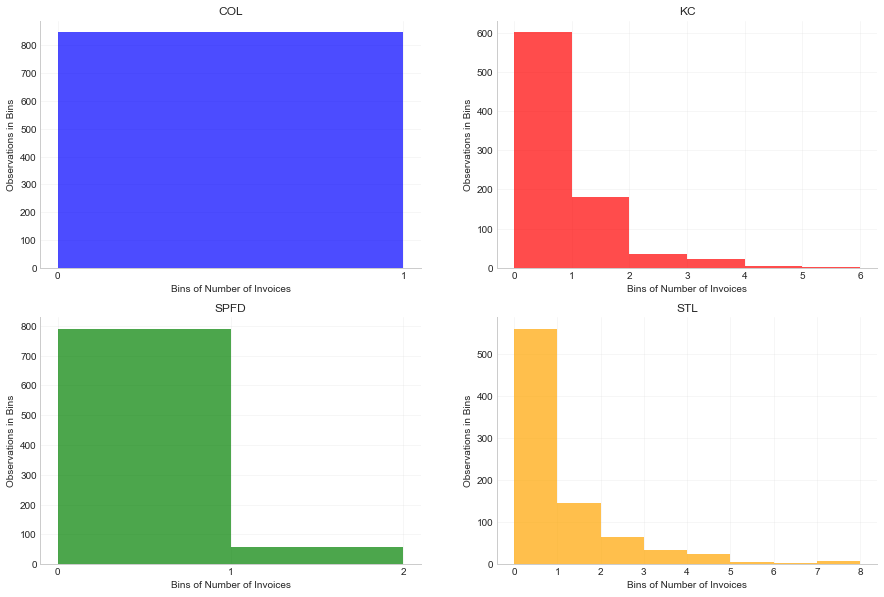

contract__billed_amount             invoice_number          
                        mean         std           mean       std
loc                                                              
COL                14.930960   97.181298       0.033097  0.178996
KC                 60.510857  172.426125       0.414894  0.792996
SPFD               25.197369  112.360039       0.089835  0.356134
STL               145.955933  435.419256       0.685579  1.275330

In [28]:
fill_fwd_bwd = lambda df_col: df_col.fillna(method='ffill').fillna(method='bfill')

hogan_daily = pd.DataFrame()
dates = pd.date_range('2016-01-01', '2018-04-25', freq='D')
for grp, df in hogan_byday.groupby('loc'):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True, drop=False)
    df = df.reindex(dates)
    df['loc'] = fill_fwd_bwd(df['loc'])
    df = df.fillna(0)
    df.reset_index(inplace=True)
    df['date'] = df['index']
    df.drop(columns='index', inplace=True)
    hogan_daily = hogan_daily.append(df)
    
import math
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
colors = ['blue', 'red', 'green', 'orange']

for i, loc in enumerate(hogan_daily['loc'].unique()):
    if i < 2: ax = axes[0, i]
    else: ax = axes[1, i-2]
    n_invoices = hogan_daily.loc[hogan_daily['loc'] == loc, 'invoice_number']
    ax.hist(n_invoices, 
            bins=int(n_invoices.max()), 
            label='Number of Invoices',
            alpha=.7, color=colors[i])
    ax.set_xlabel('Bins of Number of Invoices')
    ax.set_ylabel('Observations in Bins')
    ax.set_title(str(loc))
    ax.grid(alpha=.2)
    xint = range(0, math.ceil(max(n_invoices)+1))
    ax.set_xticks(xint)
    sns.despine()
sns.set_style('whitegrid')
plt.savefig('./figs/histogram_hogan_invoices_per_day.png')
plt.show()   

agg_funcs = {'contract__billed_amount': {'mean': np.mean, 'std': np.std},
            'invoice_number': {'mean': np.mean, 'std': np.std}}
hogan_daily.groupby('loc').agg(agg_funcs)

--------

--------

--------

# Combine Daily Report and Hogan Data

### Merge Hogan Data into Daily Report Data

Merging in `stl_daily_prdday` which is the Daily Report's Production Tab from 2016-2018.  This particular dataset contains only production days to avoid some of the noise in off-production-day planned delivery days.  

In [29]:
stl_daily_prdday.columns = [str(col).replace(' ', '_').lower() for col in stl_daily_prdday.columns]
stl_daily_prdday.rename(columns={'location': 'loc'}, inplace=True)
stl_daily_prdday['loc'] = stl_daily_prdday['loc'].astype(str)
stl_daily_prdday.set_index(['date', 'loc'], inplace=True)
hogan_daily['loc'] = hogan_daily['loc'].astype(str)
hogan_daily.set_index(['date', 'loc'], inplace=True)

In [30]:
hogan_and_daily_rpt = hogan_daily.join(stl_daily_prdday, how='inner')
hogan_and_daily_rpt['amt_per_hogan_invoice'] = np.divide(hogan_and_daily_rpt.contract__billed_amount,
                                                        hogan_and_daily_rpt.invoice_number)
hogan_and_daily_rpt.reset_index(drop=False, inplace=True)

## Quick Visualization of Combined Data

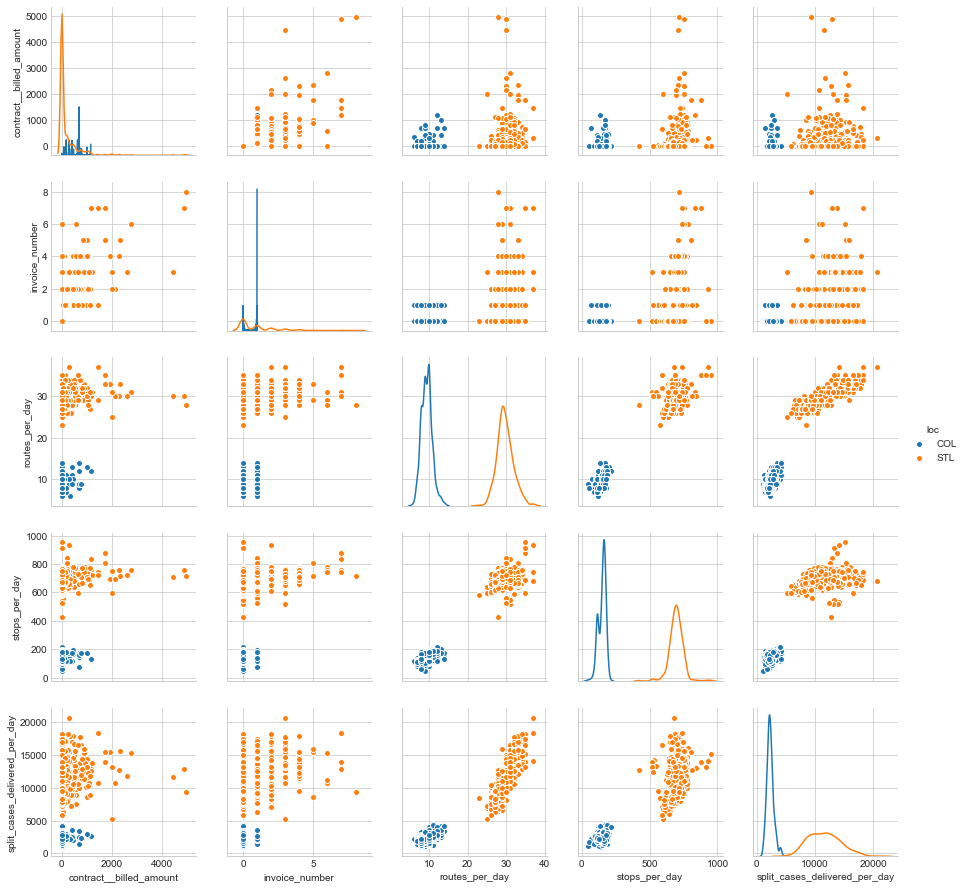

In [31]:
num_cols = ['contract__billed_amount', 'invoice_number', 
            'routes_per_day', 'stops_per_day', 
            'split_cases_delivered_per_day'] #'is_holiday_week', 'last_selling_day'
sns.pairplot(hogan_and_daily_rpt, vars=num_cols, hue='loc', diag_kind='kde')
plt.savefig('./figs/pairplot_dailyrpt_hogandata.png')

***Note we only have only COL and STL now (from Hogan) due to this merge.***

In [32]:
hogan_and_daily_rpt.groupby('loc')[['amt_per_hogan_invoice', 'invoice_number']].agg([np.mean, np.std])

amt_per_hogan_invoice             invoice_number          
                     mean         std           mean       std
loc                                                           
COL            487.197895  290.898527       0.052521  0.223310
STL            215.571175  238.978005       0.968487  1.407145

In [33]:
hogan_and_daily_rpt.head()

,date,loc,contract__billed_amount,invoice_number,warehouse,routes_per_day,stops_per_day,split_cases_delivered_per_day,month,year,weekday,is_weekday,is_holiday,is_holiday_week,is_production_day,last_selling_day,bill_and_hold,schlafly,amt_per_hogan_invoice
0,2016-01-05,COL,0.00000,0.0,STL,9,117.0,2396.0,January,2016,Tuesday,1,0,0,1,0,1,1,NaN
1,2016-01-05,STL,383.78489,4.0,STL,30,706.0,12073.0,January,2016,Tuesday,1,0,0,1,0,1,1,95.946223
2,2016-01-06,COL,0.00000,0.0,STL,11,150.0,2539.0,January,2016,Wednesday,1,0,0,1,0,0,1,NaN
3,2016-01-06,STL,128.40489,1.0,STL,29,618.0,11164.0,January,2016,Wednesday,1,0,0,1,0,0,1,128.404890
4,2016-01-07,COL,0.00000,0.0,STL,9,143.0,1802.0,January,2016,Thursday,1,0,0,1,0,0,1,NaN


------------

------------

------------

------------

# Simulate by Drawing Samples


### Extract Predictions for `splits_forecasted`

First we need to use the baseline model for split cases delivered.  Recall the columns used to predict this data are simply the `cal_df` in this order:

```
['last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september']
```

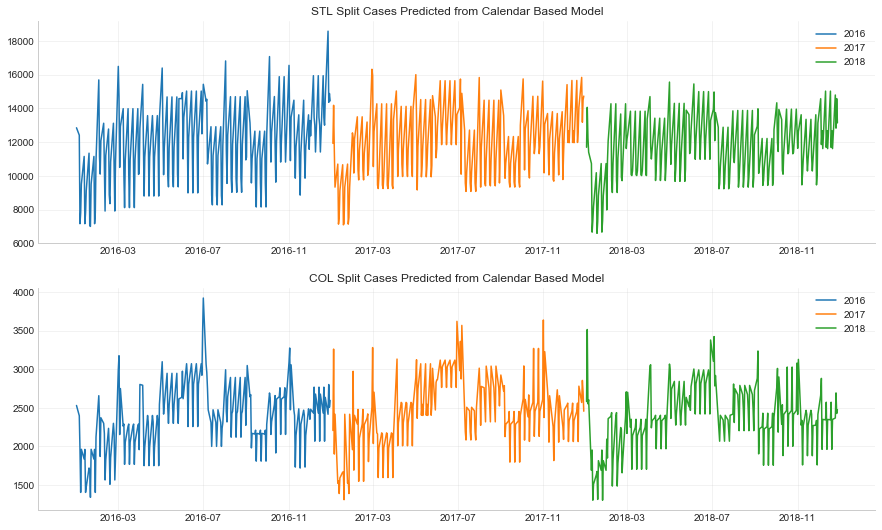

In [34]:
# generate data to predict from
year_list = ['2016', '2017', '2018']
locations = ['STL', 'COL']
predictor_cols = ['last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly', 
                 'location_col', 'location_stl', 'weekday_friday', 'weekday_thursday', 
                 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 'year_2017', 'year_2018', 
                 'month_april', 'month_august', 'month_december', 'month_february', 
                 'month_january', 'month_july', 'month_june', 'month_march', 'month_may',
                 'month_november', 'month_october', 'month_september']

def generate_split_model_data(year_list, locations, predictor_cols):
    cal_df = pd.DataFrame()
    for year in year_list:
        for loc in locations:
            _df = generate_calendar(year, drop_index=True)
            _df['location'] = loc
            _df = _df.loc[_df.is_production_day == True]
            cal_df = cal_df.append(_df)
    
    cal_df['date'] = pd.to_datetime(cal_df['date'])
    cal_df['bill_and_hold'] = [int(i) for i in cal_df['date'].dt.day.astype(int) <= 5]
    cal_df['schlafly'] = [int(i) for i in cal_df['date'] <= pd.to_datetime('2018-07-31')]
    
    dummy_cols = ['month', 'year', 'weekday', 'location']
    cal_df = pd.get_dummies(cal_df, dummy_cols, drop_first=False)
    cal_df.columns = [str(col).lower() for col in cal_df.columns]
    dates = cal_df['date']
    cal_df = cal_df[predictor_cols]
    return cal_df, dates

split_model_data, dates = generate_split_model_data(year_list, locations, predictor_cols)

model_splits = joblib.load('splits_per_day_rf.pkl')
split_model_data['splits_forecasted'] = model_splits.predict(split_model_data)
split_model_data['date'] = dates

fig, axes = plt.subplots(2, 1, figsize=(15, 9))
for i, loc in enumerate(locations):
    if loc == 'STL': is_stl = True
    else: is_stl = False
    _df = split_model_data.loc[split_model_data.location_stl == is_stl]
    ax = axes[i]
    is_2016, is_2017 = _df['date'].dt.year == 2016, _df['date'].dt.year == 2017
    is_2018 = (is_2016==False) & (is_2017==False)
    ax.plot(_df.loc[is_2016, 'date'], _df.loc[is_2016, 'splits_forecasted'], label='2016')
    ax.plot(_df.loc[is_2017, 'date'], _df.loc[is_2017, 'splits_forecasted'], label='2017')
    ax.plot(_df.loc[is_2018, 'date'], _df.loc[is_2018, 'splits_forecasted'], label='2018')
    ax.grid(alpha=.3)
    ax.legend(loc='best')
    ax.set_title(str(loc) + ' Split Cases Predicted from Calendar Based Model')
    sns.despine()
plt.savefig('./figs/split_cases_predicted_calendar_based_model.png')

### Use Predictions for `split_cases_delivered_per_day` to Predict `routes_per_day`

Recall that the following columns were used as predictors of `routes_per_day`:

```
['split_cases_delivered_per_day', 'last_selling_day', 'is_holiday_week', 'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 'month_september']
```

We already predicted `routes_per_day`, and have generated the remainder.  We will use this data as predictors.

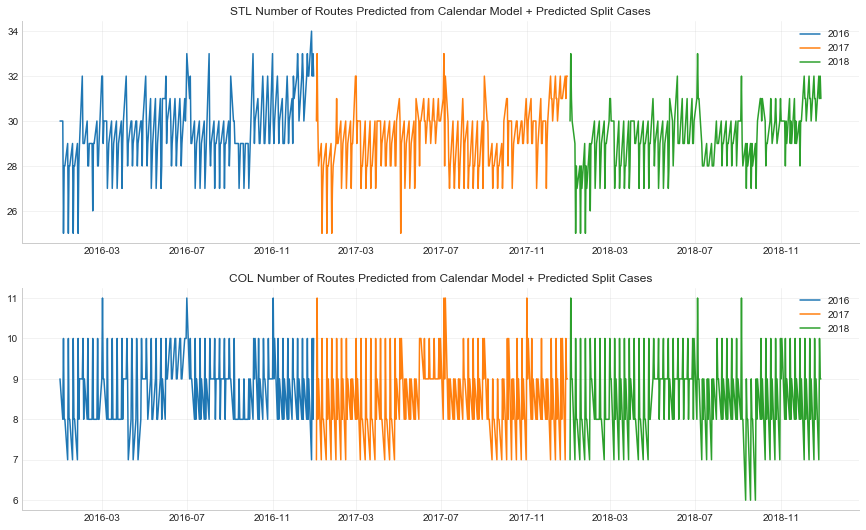

In [35]:
from math import floor
model_rtes = joblib.load('rtes_per_day_model_rf.pkl')

# note splits_forecasted used instead of split_cases_delivered_per_day
predict_cols = ['splits_forecasted', 'last_selling_day', 'is_holiday_week', 
                'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 
                'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 
                'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 
                'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 
                'month_may', 'month_november', 'month_october', 'month_september']

predict_data = split_model_data[predict_cols]
predict_data['splits_forecasted'] = predict_data['splits_forecasted'] - predict_data['splits_forecasted'].mean()
predict_data['splits_forecasted'] = predict_data['splits_forecasted'] / predict_data['splits_forecasted'].std()

split_model_data['rtes_forecasted'] = [floor(p) for p in model_rtes.predict(predict_data)]

fig, axes = plt.subplots(2, 1, figsize=(15, 9))
for i, loc in enumerate(locations):
    if loc == 'STL': is_stl = True
    else: is_stl = False
    _df = split_model_data.loc[split_model_data.location_stl == is_stl]
    ax = axes[i]
    is_2016, is_2017 = _df['date'].dt.year == 2016, _df['date'].dt.year == 2017
    is_2018 = (is_2016==False) & (is_2017==False)
    ax.plot(_df.loc[is_2016, 'date'], _df.loc[is_2016, 'rtes_forecasted'], label='2016')
    ax.plot(_df.loc[is_2017, 'date'], _df.loc[is_2017, 'rtes_forecasted'], label='2017')
    ax.plot(_df.loc[is_2018, 'date'], _df.loc[is_2018, 'rtes_forecasted'], label='2018')
    ax.grid(alpha=.3)
    ax.legend(loc='best')
    ax.set_title(str(loc) + ' Number of Routes Predicted from Calendar Model + Predicted Split Cases')
    sns.despine()
plt.savefig('./figs/num_routes_predicted_calendar_based_model.png')
# split_model_data.to_excel('Predicted Values for Daily Split Cases & Number of Routes.xlsx')

## Deriving Delivery Cost Function

***Note:  Miles as documented in the Daily Report are NOT reliable.  Thus this information is not considered because it can be easily thrown off by one of the many fat finger instances that happen when tracking this kind of data in Excel***

### Labor Cost Portion

In [36]:
def daily_labor_cost(stops, cases, routes, 
                     pay_per_stop=0.70, pay_per_case=0.2288, min_daily=200):
    daily_labor_cost = pay_per_stop * stops + pay_per_case * cases
    adj_daily_labor_cost = min_daily * routes
    daily_labor_cost = max(daily_labor_cost, adj_daily_labor_cost)
    return daily_labor_cost

daily_labor_list = list()
for i, row in hogan_and_daily_rpt[['stops_per_day', 'split_cases_delivered_per_day', 'routes_per_day']].iterrows():
    dl = daily_labor_cost(row['stops_per_day'], row['split_cases_delivered_per_day'], row['routes_per_day'])
    daily_labor_list.append(dl)
    
hogan_and_daily_rpt['actual_daily_labor_cost'] = daily_labor_list

### Cost of Leased Vehicles

Allocating cost of lease on the basis of number of production days in a given year.  

In [ ]:
def yearly_lease_cost(n_trucks, avg_monthly_lease_cost_per_truck):
    yearly_cost_all_leases = avg_monthly_lease_cost_per_truck * n_trucks * 12
    return yearly_cost_all_leases

def get_production_days(year='2018'):
    prod_days = generate_calendar(year)['is_production_day'].sum()
    return prod_days

def daily_lease_cost(yearly_production_days, yearly_cost_all_leases):
    daily_cost_leases = yearly_cost_all_leases / yearly_production_days
    return daily_cost_leases

def simulate_delivery_costs(hogan_and_daily_rpt, split_model_data,
                            leased_trucks_stl, leased_trucks_col, 
                            prod_days, avg_monthly_lease_cost_per_truck,
                            splits_model = joblib.load('splits_per_day_rf.pkl'), 
                            rtes_model = joblib.load('rtes_per_day_model_rf.pkl')):
    
    # derive standard deviations of actuals for introducing randomness
    std_splits = hogan_and_daily_rpt.groupby('loc')['split_cases_delivered_per_day'].std().to_dict()
    
    # add loc to prediction data for mapping
    hogan = hogan_and_daily_rpt.copy()
    split_model_data['loc'] = split_model_data['location_stl'].map({0: 'COL', 1: 'STL'})
    
    # map in split predictions before adding randomness
    dat_loc = split_model_data['date'].astype(str) + '_' + split_model_data['loc'].astype(str)
    splits_forecasted = dict(zip(dat_loc, split_model_data['splits_forecasted']))
    hogan['splits_forecasted'] = hogan['date'].astype(str) + '_' + hogan['loc'].astype(str)
    hogan['splits_forecasted'] = hogan['splits_forecasted'].map(splits_forecasted)
    
    # add randomness to total cases
    sim_df = hogan.copy()
    is_stl, is_col = sim_df['loc']=='STL', sim_df['loc']=='COL'
    cases_forecasted = sim_df.loc[is_stl, 'splits_forecasted'].values
    sim_df.loc[is_stl, 'splits_forecasted'] = [cs + np.random.randn() * std_splits['STL'] * 0.2
                                               for cs in cases_forecasted]
    cases_forecasted = sim_df.loc[is_col, 'splits_forecasted'].values
    sim_df.loc[is_col, 'splits_forecasted'] = [cs + np.random.randn() * std_splits['COL'] * 0.2
                                               for cs in cases_forecasted]
    
    # now re-predict n_rtes per day using new random variation of cases
    # note splits_forecasted used instead of split_cases_delivered_per_day
    predict_cols = ['splits_forecasted', 'last_selling_day', 'is_holiday_week', 
                    'bill_and_hold', 'schlafly', 'location_col', 'location_stl', 'weekday_friday', 
                    'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'year_2016', 
                    'year_2017', 'year_2018', 'month_april', 'month_august', 'month_december', 
                    'month_february', 'month_january', 'month_july', 'month_june', 'month_march', 
                    'month_may', 'month_november', 'month_october', 'month_september']
    predict_data = split_model_data[predict_cols]
    predict_data['splits_forecasted'] = predict_data['splits_forecasted'] - predict_data['splits_forecasted'].mean()
    predict_data['splits_forecasted'] = predict_data['splits_forecasted'] / predict_data['splits_forecasted'].std()
    
    # get forecast and map into sim_df
    split_model_data['rtes_forecasted'] = [int(p) for p in rtes_model.predict(predict_data)]
    rtes_forecasted = dict(zip(dat_loc, split_model_data['rtes_forecasted']))
    sim_df['rtes_forecasted'] = sim_df['date'].astype(str) + '_' + sim_df['loc'].astype(str)
    sim_df['rtes_forecasted'] = sim_df['rtes_forecasted'].map(rtes_forecasted)
    
    # get daily labor cost
    daily_labor_list = list()
    for i, row in sim_df[['stops_per_day', 'splits_forecasted', 'rtes_forecasted']].iterrows():
        dl = daily_labor_cost(row['stops_per_day'], row['splits_forecasted'], row['rtes_forecasted'])
        daily_labor_list.append(dl)
    sim_df['daily_labor_cost'] = daily_labor_list
    
    # get cost of leases 
    stl_daily_lease_cost, col_daily_lease_cost = dict(), dict()
    for year, days in prod_days.items():
        stl_yearly = yearly_lease_cost(leased_trucks_stl, 
                                       avg_monthly_lease_cost_per_truck)
        stl_daily = daily_lease_cost(days, stl_yearly)
        stl_daily_lease_cost[year] = stl_daily

        col_yearly = yearly_lease_cost(leased_trucks_col, 
                                       avg_monthly_lease_cost_per_truck)
        col_daily = daily_lease_cost(days, col_yearly)
        col_daily_lease_cost[year] = col_daily

    avg_stl_daily_allocated_lease_cost = np.mean([i for i in stl_daily_lease_cost.values()])
    avg_col_daily_allocated_lease_cost = np.mean([i for i in col_daily_lease_cost.values()])

    sim_df.loc[is_stl, 'daily_allocated_lease_cost'] = avg_stl_daily_allocated_lease_cost
    sim_df.loc[is_col, 'daily_allocated_lease_cost'] = avg_col_daily_allocated_lease_cost
    
    daily_labor_list = list()
    labor_cols = ['stops_per_day', 'splits_forecasted', 'rtes_forecasted']
    for i, row in sim_df[labor_cols].iterrows():
        dl = daily_labor_cost(stops=row['stops_per_day'], 
                              cases=row['splits_forecasted'], 
                              routes=row['rtes_forecasted'])
        daily_labor_list.append(dl)

    sim_df['daily_labor_cost'] = daily_labor_list

    # total cost at the daily level
    sim_df['total_delivery_cost'] = sim_df[['daily_allocated_lease_cost', 'daily_labor_cost']].sum(axis=1)
    
    # select columns and set index
    cols_to_round = ['daily_allocated_lease_cost', 'splits_forecasted', 'total_delivery_cost']
    sim_df[cols_to_round] = sim_df[cols_to_round].apply(lambda x: round(x, 3))
    cols_to_keep = ['date', 'loc', 'weekday', 'daily_labor_cost', 
                   'daily_allocated_lease_cost', 'splits_forecasted', 
                   'rtes_forecasted', 'total_delivery_cost', 
                   'split_cases_delivered_per_day', 'stops_per_day', 
                   'routes_per_day', 'actual_daily_labor_cost',
                   'contract__billed_amount']
    sim_df = sim_df[cols_to_keep]
    sim_df.rename(columns={'split_cases_delivered_per_day': 'Splits Actual', 
                           'stops_per_day': 'Stops Actual', 
                           'routes_per_day': 'Routes Actual'}, inplace=True)
    sim_df.rename(columns={'loc': 'location'}, inplace=True)
    sim_df.columns = [str(col).replace('_', ' ').title() for col in sim_df.columns]
    sim_df.set_index('Date', inplace=True)
    
    # derive secondary metrics for rentals & idle trucks
    is_stl, is_col = sim_df['Location']=='STL', sim_df['Location']=='COL'
    sim_df.loc[is_stl, 'Truck Leases Active'] = leased_trucks_stl
    sim_df.loc[is_col, 'Truck Leases Active'] = leased_trucks_col
    stl_differential = sim_df.loc[is_stl, 'Rtes Forecasted'] - sim_df.loc[is_stl, 'Truck Leases Active']
    sim_df.loc[is_stl, 'Rentals Needed'] = [max(0, diff) for diff in stl_differential]
    sim_df.loc[is_stl, 'Trucks Idle'] = [max(0, -1*diff) for diff in stl_differential]
    col_differential = sim_df.loc[is_col, 'Rtes Forecasted'] - sim_df.loc[is_col, 'Truck Leases Active']
    sim_df.loc[is_col, 'Rentals Needed'] = [min(max(0, diff), 1) for diff in col_differential]
    ## print('Maxing Columbia Rentals at 1 Due to Constraints')
    sim_df.loc[is_col, 'Trucks Idle'] = [max(0, -1*diff) for diff in col_differential]
    
    # derive costs of secondary metrics
    avg_rental_stl = 215
    avg_rental_col = 395
    sim_df.loc[is_stl, 'Idle Truck Cost'] = sim_df.loc[is_stl, 'Trucks Idle'] * avg_stl_daily_allocated_lease_cost
    sim_df.loc[is_col, 'Idle Truck Cost'] = sim_df.loc[is_col, 'Trucks Idle'] * avg_col_daily_allocated_lease_cost
    sim_df.loc[is_stl, 'Rental Cost'] = sim_df.loc[is_stl, 'Rentals Needed'] * avg_rental_stl
    sim_df.loc[is_col, 'Rental Cost'] = sim_df.loc[is_col, 'Rentals Needed'] * avg_rental_stl
    sim_df['Total Delivery Cost'] = sim_df['Idle Truck Cost'] + sim_df['Rental Cost'] + sim_df['Total Delivery Cost']
    sim_df = sim_df.fillna(0)
    
    # get actuals
    # total cost at the daily level
    sim_df.rename(columns={'Contract  Billed Amount': 'Hogan Bill Actual'}, inplace=True)
    cost_cols = ['Daily Allocated Lease Cost', 'Actual Daily Labor Cost', 'Hogan Bill Actual']
    sim_df['Actual Total Delivery Cost'] = sim_df[cost_cols].sum(axis=1)
    
    return sim_df


prod_days = {'2018': get_production_days('2018'), 
            '2017': get_production_days('2017'),
            '2016': get_production_days('2016')}
leased_trucks_stl = 28
leased_trucks_col = 9
avg_monthly_lease_cost_per_truck = 1425.69 # from nichole murphy

sim_df = simulate_delivery_costs(hogan_and_daily_rpt, split_model_data,
                                leased_trucks_stl, leased_trucks_col, 
                                prod_days, avg_monthly_lease_cost_per_truck,
                                splits_model = joblib.load('splits_per_day_rf.pkl'), 
                                rtes_model = joblib.load('rtes_per_day_model_rf.pkl'))
sim_df.head()

In [ ]:
def run_hypothetical_leases(sim_df, leased_trucks_stl=28, leased_trucks_col=9, 
                            avg_rental_cost=215.57, inflator=1.0):
    is_stl, is_col = sim_df['Location']=='STL', sim_df['Location']=='COL'
    sim_df.loc[is_stl, 'Hypothetical Truck Leases'] = leased_trucks_stl
    sim_df.loc[is_col, 'Hypothetical Truck Leases'] = leased_trucks_col
    daily_lease = np.divide(sim_df['Daily Allocated Lease Cost'], sim_df['Rtes Forecasted']).mean()
    sim_df.loc[is_stl, 'Hypothetical Amortized Lease Cost'] = sim_df.loc[is_stl, 'Hypothetical Truck Leases'] * daily_lease
    
    stl_differential = sim_df.loc[is_stl, 'Routes Actual'] - sim_df.loc[is_stl, 'Truck Leases Active']
    sim_df.loc[is_stl, 'Actual Trucks Idle'] = [max(0, -1*diff) for diff in stl_differential]
    sim_df.loc[is_stl, 'Actual Idle Cost'] = sim_df.loc[is_stl, 'Actual Trucks Idle'] * avg_rental_cost*inflator
    
    stl_differential = sim_df.loc[is_stl, 'Rtes Forecasted'] - sim_df.loc[is_stl, 'Hypothetical Truck Leases']
    sim_df.loc[is_stl, 'Hypothetical Simulated Rentals Needed'] = [max(0, diff) for diff in stl_differential]
    sim_df.loc[is_stl, 'Hypothetical Simulated Trucks Idle'] = [max(0, -1*diff) for diff in stl_differential]
    stl_differential = sim_df.loc[is_stl, 'Routes Actual'] - sim_df.loc[is_stl, 'Hypothetical Truck Leases']
    sim_df.loc[is_stl, 'Hypothetical Actual Rentals Needed'] = [max(0, diff) for diff in stl_differential]
    sim_df.loc[is_stl, 'Hypothetical Actual Trucks Idle'] = [max(0, -1*diff) for diff in stl_differential]
    
    # get stl costs
    sim_df.loc[is_stl, 'Hypothetical Simulated Rental Cost'] = sim_df.loc[is_stl, 'Hypothetical Simulated Rentals Needed'] * avg_rental_cost
    sim_df.loc[is_stl, 'Hypothetical Simulated Idle Cost'] = sim_df.loc[is_stl, 'Hypothetical Simulated Trucks Idle'] * avg_rental_cost*inflator #daily_lease*inflator
    sim_df.loc[is_stl, 'Hypothetical Actual Rental Cost'] = sim_df.loc[is_stl, 'Hypothetical Actual Rentals Needed'] * avg_rental_cost
    sim_df.loc[is_stl, 'Hypothetical Actual Idle Cost'] = sim_df.loc[is_stl, 'Hypothetical Actual Trucks Idle'] * avg_rental_cost*inflator # daily_lease*inflator
    
    sumcols = ['Hypothetical Actual Rental Cost', 
               'Hypothetical Actual Idle Cost', 
               'Hypothetical Amortized Lease Cost']
    sim_df.loc[is_stl, 'Hypothetical Actual Total Delivery Cost'] = sim_df.loc[is_stl, sumcols].sum(axis=1)
    sumcols = ['Hypothetical Simulated Rental Cost', 
               'Hypothetical Simulated Idle Cost', 
               'Hypothetical Amortized Lease Cost']
    sim_df.loc[is_stl, 'Hypothetical Simulated Total Delivery Cost'] = sim_df.loc[is_stl, sumcols].sum(axis=1)
    sim_df.loc[is_stl, 'Actual Total Delivery Cost - Labor'] = sim_df.loc[is_stl, 'Actual Total Delivery Cost'] - sim_df.loc[is_stl, 'Actual Daily Labor Cost']
    
    # Columbia not done on purpose for now
    
    sim_df = sim_df.fillna(0)
    
    return sim_df

sim_df = run_hypothetical_leases(sim_df, leased_trucks_stl=27, leased_trucks_col=9)

print('''
Actual vs. Forecasted Splits R2-Score = %.4f
Actual vs. Forecasted Routes R2-Score = %.4f
''' % (r2_score(sim_df['Splits Forecasted'], sim_df['Splits Actual']),
          r2_score(sim_df['Rtes Forecasted'], sim_df['Routes Actual'])))

sim_df.head()

In [ ]:
# run simulation and compare to actuals
prod_days = {'2018': get_production_days('2018'), 
            '2017': get_production_days('2017'),
            '2016': get_production_days('2016')}
avg_monthly_lease_cost_per_truck = 1425.69 # from nichole murphy
splits_model = joblib.load('splits_per_day_rf.pkl')
rtes_model = joblib.load('rtes_per_day_model_rf.pkl')
inflator = 0.0 #either magnifies or diminishes idle cost per truck per day

simulations = pd.DataFrame()
lease_range = [25, 26, 27, 28, 29, 30, 31, 32, 33] #ntrucks stl
for n, leases_stl in enumerate(lease_range):
    for i in range(100):
        sim_df = simulate_delivery_costs(hogan_and_daily_rpt, 
                                         split_model_data,
                                         leased_trucks_stl, # varying this BELOW not here
                                         leased_trucks_col, 
                                         prod_days, 
                                         avg_monthly_lease_cost_per_truck,
                                         splits_model, 
                                         rtes_model)
        sim_df = run_hypothetical_leases(sim_df, 
                                         leased_trucks_stl=leases_stl, # varying STL
                                         leased_trucks_col=9,          # hold COL constant
                                         inflator=inflator)
        sim_df = sim_df.loc[sim_df['Location'] == 'STL']
        sim_df.reset_index(inplace=True, drop=False)
        sim_df['ix'] = i
        sim_df.set_index(['ix', 'Location', 'Date'], inplace=True)
        simulations = simulations.append(sim_df)


#plot
grp_cols = ['Location', 'Hypothetical Truck Leases']
agg_funcs = {'Hypothetical Actual Total Delivery Cost': np.mean,
            'Hypothetical Simulated Total Delivery Cost': np.mean,
            'Actual Total Delivery Cost - Labor': np.mean}
summary = simulations.groupby(grp_cols).agg(agg_funcs)
summary.rename(columns={'level_2': 'variable', 0: 'value'}, inplace=True)
summary.reset_index(drop=False, inplace=True)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(summary['Hypothetical Truck Leases'], summary['Hypothetical Actual Total Delivery Cost'],
       label='Historical Cost if @ Truck Leases', color='black', linestyle='--')
ax.plot(summary['Hypothetical Truck Leases'], summary['Hypothetical Simulated Total Delivery Cost'],
       label='Simulated Cost if @ Truck Leases', color='blue', linestyle='-.')
ax.set_xlabel('Number of Leases')
ax.set_ylabel('Average Lease Cost + Rental Cost + Idle Cost per Day')
ax.set_title('Average Daily Delivery Cost (STL)\nIdle Cost is %i x Rental Cost' %inflator)
ax.grid(alpha=.3)
ax.legend(loc='best')
plt.ticklabel_format(style='plain', axis='y')
sns.despine()
plt.savefig('./figs/cost_function_n_leases_inflating_idle_cost_'+str(inflator)+'.png')

summary

In [ ]:
# run simulation and compare to actuals
prod_days = {'2018': get_production_days('2018'), 
            '2017': get_production_days('2017'),
            '2016': get_production_days('2016')}
avg_monthly_lease_cost_per_truck = 1425.69 # from nichole murphy
splits_model = joblib.load('splits_per_day_rf.pkl')
rtes_model = joblib.load('rtes_per_day_model_rf.pkl')
#inflator = 1.0 #either magnifies or diminishes idle cost per truck per day

fig, axes = plt.subplots(2, 2, figsize=(17, 12))
simulations = pd.DataFrame()
inflator_range = [0, .5, 1, 2]

for i, inflator in enumerate(inflator_range):
    lease_range = [25, 26, 27, 28, 29, 30, 31, 32, 33] #n truck leases stl
    for n, leases_stl in enumerate(lease_range):
        for j in range(25):
            sim_df = simulate_delivery_costs(hogan_and_daily_rpt, 
                                             split_model_data,
                                             leased_trucks_stl, # varying this BELOW not here
                                             leased_trucks_col, 
                                             prod_days, 
                                             avg_monthly_lease_cost_per_truck,
                                             splits_model, 
                                             rtes_model)
            sim_df = run_hypothetical_leases(sim_df, 
                                             leased_trucks_stl=leases_stl, # varying STL
                                             leased_trucks_col=9,          # hold COL constant
                                             inflator=i)
            sim_df = sim_df.loc[sim_df['Location'] == 'STL']
            sim_df.reset_index(inplace=True, drop=False)
            sim_df['ix'] =str(i) + '_' + str(n) + '_' + str(j)
            sim_df.set_index(['ix', 'Location', 'Date'], inplace=True)
            simulations = simulations.append(sim_df)


        #plot
        if i < 2: ax = axes[0, i]
        else: ax = axes[1, i-2]
            
        grp_cols = ['Location', 'Hypothetical Truck Leases']
        agg_funcs = {'Hypothetical Actual Total Delivery Cost': np.mean,
                    'Hypothetical Simulated Total Delivery Cost': np.mean,
                    'Actual Total Delivery Cost - Labor': np.mean}
        summary = simulations.groupby(grp_cols).agg(agg_funcs)
        summary.rename(columns={'level_2': 'variable', 0: 'value'}, inplace=True)
        summary.reset_index(drop=False, inplace=True)

        ax.plot(summary['Hypothetical Truck Leases'], summary['Hypothetical Actual Total Delivery Cost'],
               label='Historical Cost if @ Truck Leases', color='black', linestyle='--')
        ax.plot(summary['Hypothetical Truck Leases'], summary['Hypothetical Simulated Total Delivery Cost'],
               label='Simulated Cost if @ Truck Leases', color='blue', linestyle='-.')
        ax.set_xlabel('Number of Leases')
        ax.set_ylabel('Average Lease Cost + Rental Cost + Idle Cost per Day')
        ax.set_title('Average Daily Delivery Cost (STL)\nIdle Cost is %i x Rental Cost' %inflator)
        hypsimcol = 'Hypothetical Simulated Total Delivery Cost'
        ax.axhline(summary[hypsimcol].min(), label='Min of Cost Function', color='lightgreen', linestyle=':')
        ax.grid(alpha=.3)
        ax.legend(loc='best')
        plt.ticklabel_format(style='plain', axis='y')
        sns.despine()

plt.savefig('./figs/cost_function_n_leases_inflating_idle_cost_'+str(inflator)+'.png')
plt.show()

---------

-----------

---------------

---

---

---

# Empirical Test of the Schlafly Effect

## Ordinary Least Squares

In [44]:
import statsmodels.api as sm
from statsmodels.api import OLS

def sm_linear_regression(Y, X, intercept=True):
    if intercept: X = sm.add_constant(X)
    lin_model = sm.OLS(Y, X)
    lin_model_results = lin_model.fit()
    print(lin_model_results.summary())
    return lin_model_results

def sm_linear_prediction(X_test, ols_results, intercept=True):
    if intercept: X_test = sm.add_constant(X_test)
    Y_hat = ols_results.predict(X_test)
    return Y_hat

y_col = 'split_cases_delivered_per_day'
leave_out = ['date', 'stops_per_day', 'routes_per_day', 'year_2016', 'year_2017', 'year_2018',
             'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 
             'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 
             'month_september', 'is_holiday_week', 'location_col'] + [y_col]
X_cols = [col for col in df_modeling.columns if col not in leave_out]
continuous_cols = []

X_train, X_test, y_train, y_test, std_scaler = split_scale_data(df_modeling, 
                                                               y_col, 
                                                               leave_out, 
                                                               train_size=.7,
                                                               continuous_cols=continuous_cols)

# split off hold out set
pct_hold_out = .5
nrow_train = int(pct_hold_out * X_test.shape[0])
X_val, y_val = X_test.iloc[:nrow_train], y_test.iloc[:nrow_train]
X_test, y_test = X_test.iloc[nrow_train:], y_test.iloc[nrow_train:]

ols_results = sm_linear_regression(y_train, X_train)
y_predict = sm_linear_prediction(X_test, ols_results)
r2_test = r2_score(y_test, y_predict)
r2_train = r2_score(y_train, sm_linear_prediction(X_train, ols_results))
print('\nR-squared training = %5f\nR-squared testing = %5f\n' %(r2_train, r2_test))

Using X columns:
['last_selling_day', 'bill_and_hold', 'schlafly', 'location_stl', 'weekday_friday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday']
To predict Y column:
split_cases_delivered_per_day
                                  OLS Regression Results                                 
Dep. Variable:     split_cases_delivered_per_day   R-squared:                       0.882
Model:                                       OLS   Adj. R-squared:                  0.881
Method:                            Least Squares   F-statistic:                     705.2
Date:                           Mon, 30 Apr 2018   Prob (F-statistic):          1.03e-301
Time:                                   16:10:21   Log-Likelihood:                -5940.6
No. Observations:                            669   AIC:                         1.190e+04
Df Residuals:                                661   BIC:                         1.193e+04
Df Model:                                      7                    

A logistic regression model is used to test whether if we were to leave out the columns:

```
# the model is blind to these columns
['date', 'stops_per_day', 'routes_per_day', 'year_2016', 'year_2017', 'year_2018',
 'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 
 'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 
 'month_september', 'last_selling_day', 'is_holiday_week', 'bill_and_hold']
```

would we be able to predict whether Schlafly was an active supplier at that time?  This is after adjusting for weekday, bill and hold, holiday weeks, and split cases per day.  The key here is that `split_cases_delivered_per_day` should, if losing Schlafly really "hurt" us badly, contain enough signal to predict the `schafly` zero or one indicator.  

In [ ]:
df_modeling.columns

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')

y_col = 'schlafly'
leave_out = ['date', 'stops_per_day', 'routes_per_day', 'year_2016', 'year_2017', 'year_2018',
             'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 
             'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 
             'month_september', 'last_selling_day', 'is_holiday_week', 'bill_and_hold'] + [y_col]
X_cols = [col for col in df_modeling.columns if col not in leave_out]
continuous_cols = ['split_cases_delivered_per_day']

X_train, X_test, y_train, y_test, std_scaler = split_scale_data(df_modeling, 
                                                               y_col, 
                                                               leave_out, 
                                                               train_size=.7,
                                                               continuous_cols=continuous_cols)

# split off hold out set
pct_hold_out = .5
nrow_train = int(pct_hold_out * X_test.shape[0])
X_val, y_val = X_test.iloc[:nrow_train], y_test.iloc[:nrow_train]
X_test, y_test = X_test.iloc[nrow_train:], y_test.iloc[nrow_train:]

param_grid = {'C': np.arange(1, 11, 1),
             'penalty': ['l1']}
model = LogisticRegression(n_jobs=-1, random_state=7)

grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

val_score = accuracy_score(y_val, [int(pred) for pred in grid.predict(X_val)])
test_score = accuracy_score(y_test, [int(pred) for pred in grid.predict(X_test)])
train_score = accuracy_score(y_train, [int(pred) for pred in grid.predict(X_train)])

print('Train Score = {}, Validation Score = {}, Test Score = {}'
      .format(train_score, val_score, test_score))

joblib.dump(grid.best_estimator_, 'logistic_test_of_schlafly_effect.pkl')

print(grid.best_params_)
pd.DataFrame({'coefficients': grid.best_estimator_.coef_[0],
             'X_col': X_cols})

## Test `sklearn.linear_model.Lasso`  

***Test WITH Schlafly as a predictor***

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')

y_col = 'split_cases_delivered_per_day'
leave_out = ['date', 'stops_per_day', 'routes_per_day', 'year_2016', 'year_2017', 'year_2018',
             'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 
             'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 
             'month_september', 'last_selling_day', 'is_holiday_week', 'bill_and_hold', 'location_col'] + [y_col]
X_cols = [col for col in df_modeling.columns if col not in leave_out]
continuous_cols = []

X_train, X_test, y_train, y_test, std_scaler = split_scale_data(df_modeling, 
                                                               y_col, 
                                                               leave_out, 
                                                               train_size=.7,
                                                               continuous_cols=continuous_cols)

# split off hold out set
pct_hold_out = .5
nrow_train = int(pct_hold_out * X_test.shape[0])
X_val, y_val = X_test.iloc[:nrow_train], y_test.iloc[:nrow_train]
X_test, y_test = X_test.iloc[nrow_train:], y_test.iloc[nrow_train:]

param_grid = {'alpha': np.arange(0.1, 10.5, .5)}
model = Lasso(random_state=7)

grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

val_score = r2_score(y_val, [int(pred) for pred in grid.predict(X_val)])
test_score = r2_score(y_test, [int(pred) for pred in grid.predict(X_test)])
train_score = r2_score(y_train, [int(pred) for pred in grid.predict(X_train)])

print('Train Score = {}, Validation Score = {}, Test Score = {}'
      .format(train_score, val_score, test_score))

joblib.dump(grid.best_estimator_, 'lasso_regression_test_of_schlafly_effect.pkl')

print(grid.best_params_)
pd.DataFrame({'coefficients': grid.best_estimator_.coef_[0],
             'X_col': X_cols})

***Test WITHOUT Schlafly as a predictor***

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.externals import joblib

y_col = 'split_cases_delivered_per_day'
leave_out = ['date', 'stops_per_day', 'routes_per_day', 'year_2016', 'year_2017', 'year_2018',
             'month_april', 'month_august', 'month_december', 'month_february', 'month_january', 
             'month_july', 'month_june', 'month_march', 'month_may', 'month_november', 'month_october', 
             'month_september', 'last_selling_day', 'is_holiday_week', 'bill_and_hold', 'location_col', 
             'schlafly'] + [y_col]
X_cols = [col for col in df_modeling.columns if col not in leave_out]
continuous_cols = []

X_train, X_test, y_train, y_test, std_scaler = split_scale_data(df_modeling, 
                                                               y_col, 
                                                               leave_out, 
                                                               train_size=.7,
                                                               continuous_cols=continuous_cols)

# split off hold out set
pct_hold_out = .5
nrow_train = int(pct_hold_out * X_test.shape[0])
X_val, y_val = X_test.iloc[:nrow_train], y_test.iloc[:nrow_train]
X_test, y_test = X_test.iloc[nrow_train:], y_test.iloc[nrow_train:]

param_grid = {'alpha': np.arange(0.1, 10.5, .5)}
model = Lasso(random_state=7)

grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

val_score = r2_score(y_val, [int(pred) for pred in grid.predict(X_val)])
test_score = r2_score(y_test, [int(pred) for pred in grid.predict(X_test)])
train_score = r2_score(y_train, [int(pred) for pred in grid.predict(X_train)])

print('Train Score = {}, Validation Score = {}, Test Score = {}'
      .format(train_score, val_score, test_score))

# joblib.dump(grid.best_estimator_, 'lasso_regression_test_of_schlafly_effect.pkl')

print(grid.best_params_)
pd.DataFrame({'coefficients': grid.best_estimator_.coef_[0],
             'X_col': X_cols})

In [46]:
stl_daily_prdday.reset_index(drop=False, inplace=True)

In [47]:
def boxplot_columns_over_groups(df, cols_to_boxplot, unique_groups, 
                                grpcol_name, treatment_col,
                                savefig=False, fname='fig.png'):
    plt.clf()
    positions = np.arange(1, df[treatment_col].unique().shape[0]+1)
    ncols_to_plot, ngroups = len(cols_to_boxplot), len(unique_groups)
    fig, axes = plt.subplots(ncols_to_plot, ngroups, figsize=(ngroups*7, ncols_to_plot*5))
    for i, col in enumerate(cols_to_boxplot):
        for j, grp in enumerate(unique_groups):
            in_group = df[grpcol_name] == grp
            _df = df.loc[in_group, [treatment_col, grpcol_name, col]]
            treated = _df[treatment_col]==0
            ax = axes[i, j]
            _df.boxplot(col, by=treatment_col, ax=ax)
            ax.set_title(str(col).replace('_', ' ').title() + ' for ' + str(grp))
            ax.grid(alpha=.3)
            ax.set_xlabel(treatment_col)
            ax.set_ylabel(col)
    sns.despine()
    plt.savefig(fname)
    plt.show()

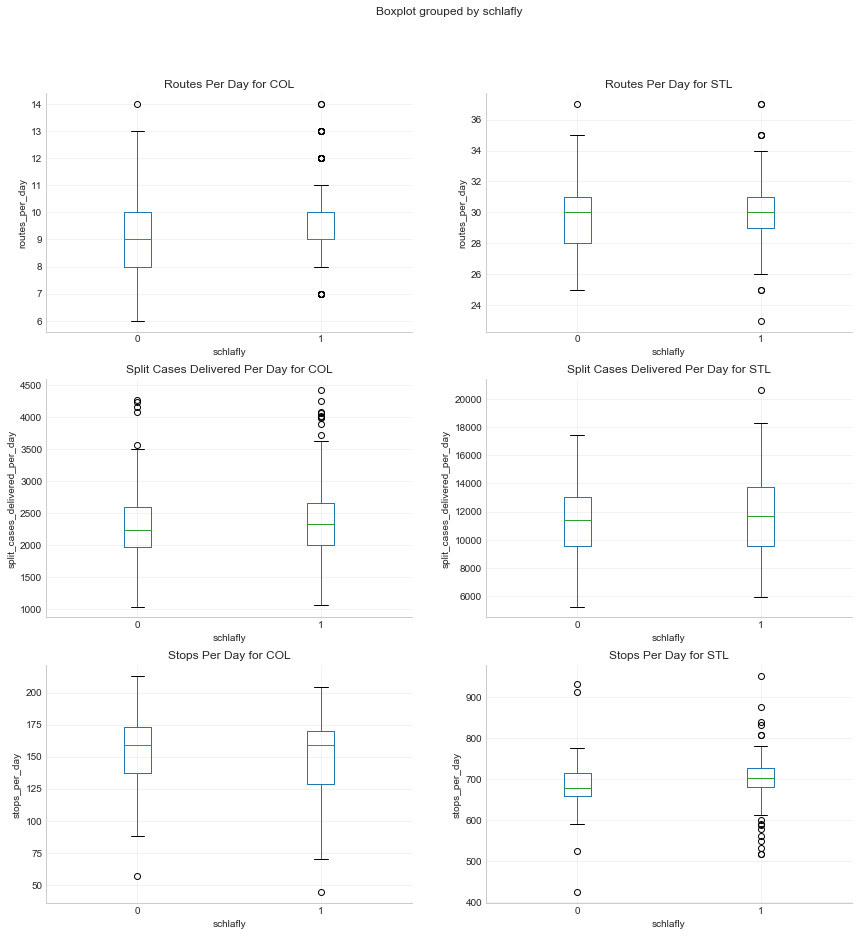

In [48]:
cols_to_boxplot = ['routes_per_day', 'split_cases_delivered_per_day', 'stops_per_day']
unique_groups = stl_daily_prdday['loc'].unique()
grpcol_name = 'loc'
treatment_col = 'schlafly'
    
boxplot_columns_over_groups(stl_daily_prdday, cols_to_boxplot, unique_groups, grpcol_name, treatment_col,
                           savefig=True, fname='./figs/boxplots_schlafly_comparison_stl_col.png')

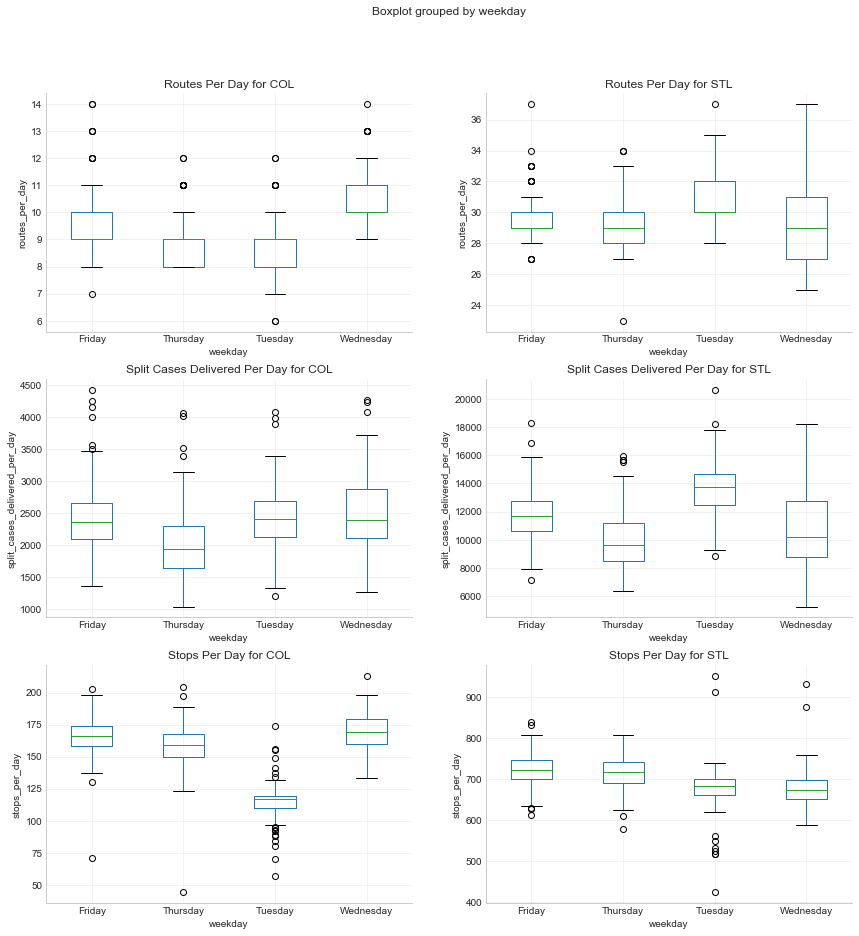

In [49]:
treatment_col = 'weekday'

boxplot_columns_over_groups(stl_daily_prdday, cols_to_boxplot, unique_groups, grpcol_name, treatment_col,
                           savefig=True, fname='./figs/boxplots_weekday_comparison_stl_col.png')

----------------------

----------------------

----------------------

## Visualize Time Series of Number of Invoices and Amount

In [40]:
hogan_daily.reset_index(drop=False, inplace=True)

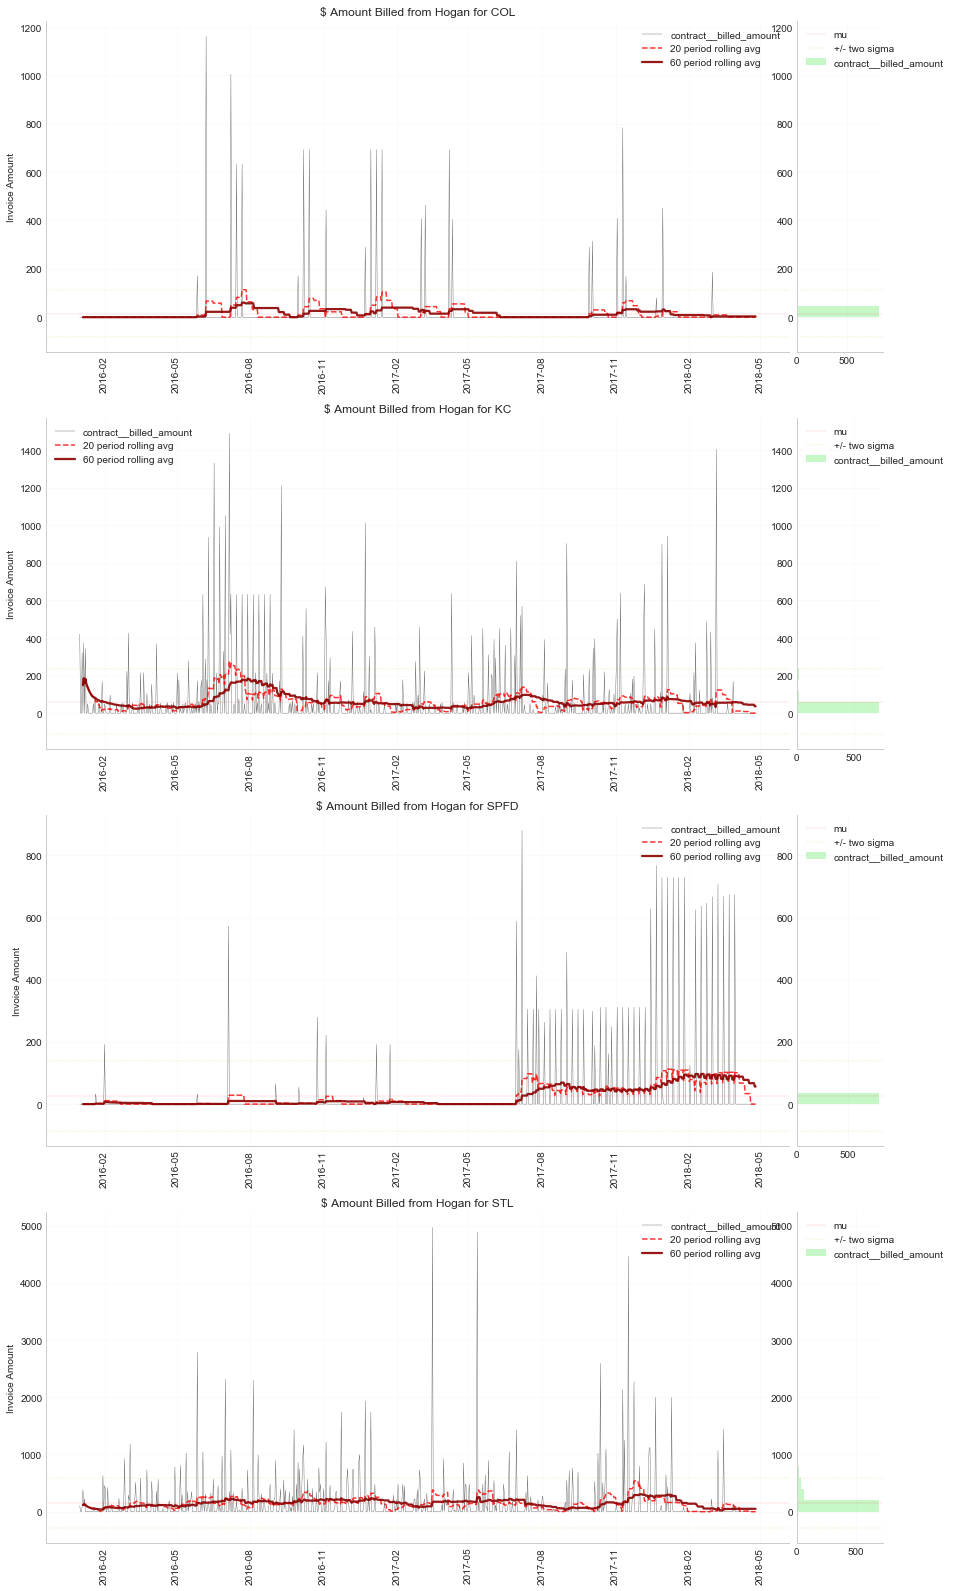

In [41]:
title_prepend = '$ Amount Billed from Hogan for {}'
xcol = 'date'
ycol = 'contract__billed_amount'
grpcol = 'loc'
labs = dict(xlab='', ylab='Invoice Amount')

plot_tseries_over_group_with_histograms(hogan_daily, xcol, ycol, grpcol, 
                                       title_prepend, labs, x_angle=90, logy=False,
                                       savefig=True,
                                       fname='./figs/tseries_amt_billed_hogan.png')

In [42]:
hogan_daily.loc[(hogan_daily.invoice_number == 2) & (hogan_daily['loc'] == 'COL')]

,date,loc,contract__billed_amount,invoice_number


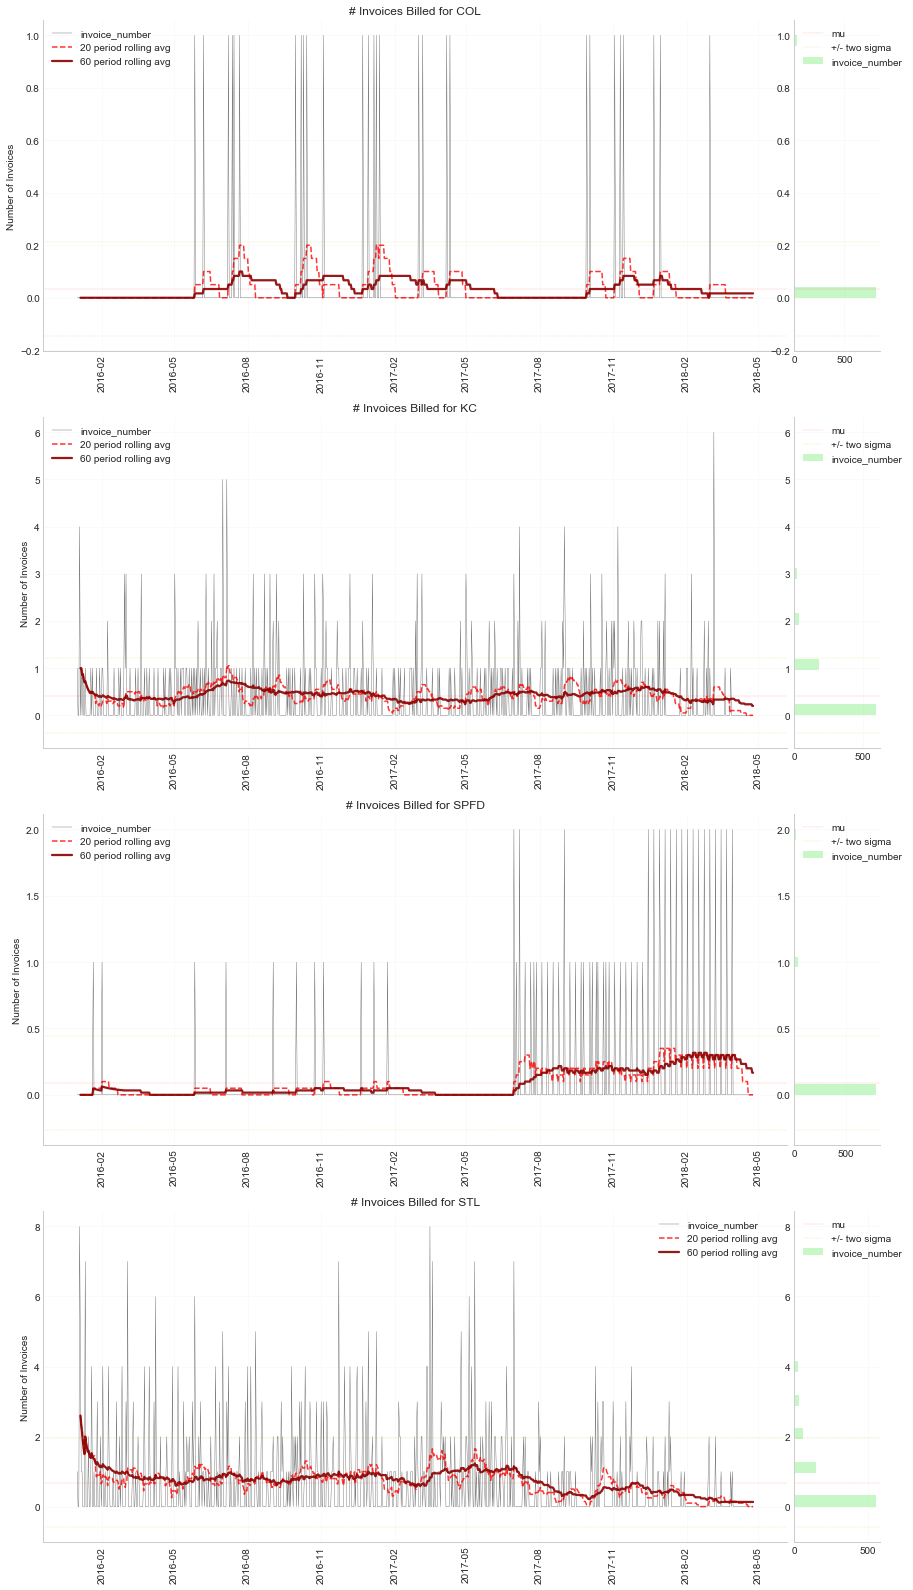

In [43]:
title_prepend = '# Invoices Billed for {}'
xcol = 'date'
ycol = 'invoice_number'
grpcol = 'loc'
labs = dict(xlab='', ylab='Number of Invoices')

plot_tseries_over_group_with_histograms(hogan_daily, xcol, ycol, grpcol, 
                                        title_prepend, labs, x_angle=90,
                                       savefig=True,
                                       fname='./figs/tseries_num_invoices_hogan.png')

------------------

------------------

------------------

# Delivery Equipment Leasing 2016-2018

This data comes directly from the general ledger and is minimally processed.

In [ ]:
equip_leasing_xlsx = pd.ExcelFile(base_dir + 'Delivery Equipment Leasing  2016-2018.xlsx')
rentals = equip_leasing_xlsx.parse('All Data', skiprows=4)
rentals.Location = rentals.Location.map({1: 'Kansas City', 2: 'Saint Louis', 3: 'Columbia', 4: 'Springfield'})
rentals.Date = rentals.Date.apply(pd.to_datetime)
equip_leasing_xlsx.close()

In [ ]:
aggfuncs = {'Amount': np.sum, 'Reference': pd.Series.nunique}
grpcols = ['Location', 'Date']
rentals_daily = pd.DataFrame(rentals.groupby(grpcols).agg(aggfuncs)).reset_index(drop=False)

In [ ]:
pd.pivot_table(rentals_daily, values=['Amount', 'Reference'], columns=['Location'], index='Date')

In [ ]:
rentals_daily.head()

In [ ]:
title_prepend = '$ Amount from Accounting for {}'
xcol = 'Date'
ycol = 'Amount'
grpcol = 'Location'
labs = dict(xlab='', ylab='Rental $ Incurred')
    
plot_tseries_over_group_with_histograms(rentals_daily, xcol, ycol, grpcol, 
                                       title_prepend, labs, x_angle=90,
                                       window=2,
                                       savefig=True,
                                       fname='./figs/tseries_accounting_amount_billed_hogan.png')

In [ ]:
title_prepend = 'Unique Invoice References from Accounting for {}'
labs = dict(xlab='', ylab='Number of Unique Invoice References')
plot_tseries_over_group_with_histograms(rentals_daily, xcol, 'Reference', grpcol, title_prepend, labs, x_angle=90, 
                                       window=2,
                                       savefig=True,
                                       fname='./figs/tseries_accounting_invoice_refs_hogan.png')